In [1]:
pip install hugchat

In [ ]:
import asyncio
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time
from hugchat.hugchat import ChatBot
from hugchat.login import Login
import json
import sys
import re
import os

# Constants
GRID_SIZE = 15
NUM_BUILDINGS = 7
NUM_CIVILIANS = 8
NUM_FIRES = 5
MAX_STEPS = 50
SENSOR_RANGE = 2

# Cell types
EMPTY = 0
BUILDING = 1
CIVILIAN = 2
FIRE = 3
AGENT = 4
STATION = 5

# Custom color mapping
COLORS = {
    EMPTY: "lightgray",
    BUILDING: "yellow",
    CIVILIAN: "blue",
    FIRE: "red",
    AGENT: "green",
    STATION: "purple"
}
DISCOVERED_COLORS = COLORS.copy()
DISCOVERED_COLORS[-1] = "black"

# Create custom colormaps
FULL_CMAP = ListedColormap([COLORS[i] for i in range(6)])
DISCOVERED_CMAP = ListedColormap([DISCOVERED_COLORS[i] for i in sorted(DISCOVERED_COLORS.keys())])

# Legend labels
COLOR_LEGEND = {
    "Empty (0)": COLORS[EMPTY],
    "Building (1)": COLORS[BUILDING],
    "Civilian (2)": COLORS[CIVILIAN],
    "Fire (3)": COLORS[FIRE],
    "Agent (4)": COLORS[AGENT],
    "Station (5)": COLORS[STATION],
    "Unknown (-1)": DISCOVERED_COLORS[-1]
}

class Environment:
    def __init__(self):
        self.grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
        self.civilians_rescued = 0
        self.fires_extinguished = 0
        self.score = 0
        self.steps = 0
        self.setup_environment()

    def setup_environment(self):
        self.grid[0, 0] = STATION
        self.grid[14, 14] = STATION
        for _ in range(NUM_BUILDINGS):
            self.place_random_entity(BUILDING)
        for _ in range(NUM_CIVILIANS):
            self.place_random_entity(CIVILIAN)
        for _ in range(NUM_FIRES):
            self.place_random_entity(FIRE)

    def place_random_entity(self, entity):
        while True:
            x, y = random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)
            if self.grid[x, y] == EMPTY:
                self.grid[x, y] = entity
                break

    def spread_fire(self):
        fire_positions = list(zip(*np.where(self.grid == FIRE)))
        if not fire_positions:
            return
        for x, y in fire_positions[:]:
            directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            random.shuffle(directions)
            for dx, dy in directions:
                new_x, new_y = x + dx, y + dy
                if (0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE and
                    self.grid[new_x, new_y] not in [FIRE, BUILDING, STATION, AGENT]):
                    if self.grid[new_x, new_y] == CIVILIAN:
                        self.score -= 100
                        print(f"Civilian died in fire! Score/MQ: {self.score}")
                    self.grid[new_x, new_y] = FIRE
                    break

    def get_grid(self):
        return self.grid

    def update_cell(self, x, y, value):
        self.grid[x, y] = value

    def increment_step(self):
        self.steps += 1

    def is_game_over(self):
        return self.steps >= MAX_STEPS or (self.fires_extinguished == NUM_FIRES and self.civilians_rescued == NUM_CIVILIANS)

    def apply_action(self, x, y, action, last_cell_content):
        """
        Apply the specified action at position (x, y) based on the last known cell content.
        Returns True if the action was successful, False otherwise.
        """
        if action == "extinguish" and last_cell_content == FIRE:
            self.update_cell(x, y, EMPTY)  # Update grid to EMPTY
            self.fires_extinguished += 1
            self.score += 10
            print(f"Fire extinguished! Score: {self.score}")
            return True
        elif action == "rescue" and last_cell_content == CIVILIAN:
            self.update_cell(x, y, EMPTY)  # Update grid to EMPTY
            return True  # Note: civilians_rescued is incremented in deliver civilian
        elif action == "drop" and last_cell_content == STATION:
            self.civilians_rescued += 1
            self.score += 50
            print(f"Civilian rescued! Score: {self.score}")
            return True
        return False

class LLMAgent:
    def __init__(self, environment, email, password):
        self.env = environment
        self.pos = None
        self.discovered_map = np.full((GRID_SIZE, GRID_SIZE), -1)
        self.carrying_civilian = False
        self.known_fires = []
        self.known_civilians = []
        self.known_buildings = []
        self.stations = [(0, 0), (14, 14)]
        self.llm_responses = []
        self.chatbot = self.initialize_chatbot(email, password)
        self.last_cell_content = EMPTY  # Track the cell's content before AGENT overwrite
        self.place_agent()
        self.update_discovered_map()

    def initialize_chatbot(self, email, password):
        sign = Login(email, password)
        cookies = sign.login()
        chatbot = ChatBot(cookies=cookies.get_dict())
        return chatbot

    def place_agent(self):
        while True:
            x, y = random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)
            if self.env.get_grid()[x, y] == EMPTY:
                self.env.update_cell(x, y, AGENT)
                self.pos = [x, y]
                self.last_cell_content = EMPTY
                break
        self.discovered_map[0, 0] = STATION
        self.discovered_map[14, 14] = STATION

    def update_discovered_map(self):
        x, y = self.pos
        for i in range(max(0, x - SENSOR_RANGE), min(GRID_SIZE, x + SENSOR_RANGE + 1)):
            for j in range(max(0, y - SENSOR_RANGE), min(GRID_SIZE, y + SENSOR_RANGE + 1)):
                cell = self.env.get_grid()[i, j]
                self.discovered_map[i, j] = cell
                pos = (i, j)
                if cell == FIRE and pos not in self.known_fires:
                    self.known_fires.append(pos)
                elif cell == CIVILIAN and pos not in self.known_civilians:
                    self.known_civilians.append(pos)
                elif cell == BUILDING and pos not in self.known_buildings:
                    self.known_buildings.append(pos)
                if cell != FIRE and pos in self.known_fires:
                    self.known_fires.remove(pos)
                if cell != CIVILIAN and pos in self.known_civilians:
                    self.known_civilians.remove(pos)

    def get_perception_view(self):
        x, y = self.pos
        view = np.full((5, 5), -1, dtype=int)
        for i in range(-SENSOR_RANGE, SENSOR_RANGE + 1):
            for j in range(-SENSOR_RANGE, SENSOR_RANGE + 1):
                grid_x, grid_y = x + i, y + j
                view_i, view_j = i + SENSOR_RANGE, j + SENSOR_RANGE
                if 0 <= grid_x < GRID_SIZE and 0 <= grid_y < GRID_SIZE:
                    view[view_i, view_j] = self.discovered_map[grid_x, grid_y]
        return view

    def get_nearest_station(self):
        x, y = self.pos
        distances = [abs(x - sx) + abs(y - sy) for sx, sy in self.stations]
        min_distance = min(distances)
        nearest_station = self.stations[distances.index(min_distance)]
        return nearest_station, min_distance

    def generate_prompt(self):
        perception_view = self.get_perception_view()
        nearest_station, distance = self.get_nearest_station()
        prompt = f"""
[AGENT STATE]
Gird size:({GRID_SIZE}, {GRID_SIZE})
Position: ({self.pos[0]}, {self.pos[1]})
Sensor View: {perception_view.tolist()}
Known Fires: {self.known_fires}
Known Civilians: {self.known_civilians}
Carrying Civilian: {'Yes' if self.carrying_civilian else 'No'}
Last Cell Content: {self.last_cell_content} (0=Empty, 2=Civilian, 3=Fire, 5=Station)
Nearest Station: {nearest_station} (Distance: {distance})
Score: {self.env.score}
Time Left: {MAX_STEPS - self.env.steps} steps

[GOAL AND PRIORITY]
Extinguish fires, rescue civilians, and avoid penalties.

[ACTION]
Choose one valid action from the following:
- Move up: Move to ({self.pos[0]-1}, {self.pos[1]}) if not a building or out of bounds({GRID_SIZE}, {GRID_SIZE})
- Move down: Move to ({self.pos[0]+1}, {self.pos[1]}) if not a building or out of bounds({GRID_SIZE}, {GRID_SIZE})
- Move left: Move to ({self.pos[0]}, {self.pos[1]-1}) if not a building or out of bounds({GRID_SIZE}, {GRID_SIZE})
- Move right: Move to ({self.pos[0]}, {self.pos[1]+1}) if not a building or out of bounds({GRID_SIZE}, {GRID_SIZE})
- Extinguish fire: If last cell content was a fire
- Rescue civilian: If last cell content was a civilian and not carrying one
- Deliver civilian: If last cell content was a station and carrying a civilian

Respond with the chosen action in this format (JSON):
'''
{{
  "action": "move up|move down|move left|move right|extinguish fire|rescue civilian|deliver civilian",
  "reasoning": "Explanation of why this action was chosen."
}}
'''
"""
        return prompt

    def validate_action(self, action):
        x, y = self.pos
        if action == "extinguish fire":
            return self.last_cell_content == FIRE
        elif action == "rescue civilian":
            return self.last_cell_content == CIVILIAN and not self.carrying_civilian
        elif action == "deliver civilian":
            return self.last_cell_content == STATION and self.carrying_civilian
        elif action in ["move up", "move down", "move left", "move right"]:
            new_x, new_y = x, y
            if action == "move up":
                new_x -= 1
            elif action == "move down":
                new_x += 1
            elif action == "move left":
                new_y -= 1
            elif action == "move right":
                new_y += 1
            return (0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE and
                    (self.discovered_map[new_x, new_y] == -1 or self.discovered_map[new_x, new_y] != BUILDING))
        return False

    def get_fallback_action(self):
        valid_actions = []
        for action in ["move up", "move down", "move left", "move right", "extinguish fire", "rescue civilian", "deliver civilian"]:
            if self.validate_action(action):
                valid_actions.append(action)
        return random.choice(valid_actions) if valid_actions else None

    async def move(self):
        self.update_discovered_map()
        prompt = self.generate_prompt()
        response_entry = {"step": self.env.steps, "prompt": prompt, "action": None, "reasoning": None, "fallback": False}
        try:
            response = await asyncio.wait_for(
                asyncio.to_thread(self.chatbot.chat, prompt),
                timeout=10
            )
            response_text = response.text if hasattr(response, 'text') else str(response)

            if not response_text.strip():
                raise ValueError("Empty response from LLM")

            json_match = re.search(r'```json\n([\s\S]*?)\n```', response_text)
            if json_match:
                json_str = json_match.group(1)
            else:
                json_start = response_text.find('{')
                json_end = response_text.rfind('}') + 1
                if json_start != -1 and json_end != 0:
                    json_str = response_text[json_start:json_end]
                else:
                    raise ValueError("No valid JSON found in response")

            llm_output = json.loads(json_str)
            action = llm_output.get("action", "")
            reasoning = llm_output.get("reasoning", "No reasoning provided.")
            print(f"Step {self.env.steps}")
            print(f"LLM Action: {action}")
            print(f"Reasoning: {reasoning}")

            response_entry["action"] = action
            response_entry["reasoning"] = reasoning

            if self.validate_action(action):
                self.execute_action(action)
            else:
                print(f"Invalid action: {action}. Choosing fallback action.")
                fallback = self.get_fallback_action()
                if fallback:
                    print(f"Fallback Action: {fallback}")
                    response_entry["action"] = fallback
                    response_entry["reasoning"] = "Fallback action chosen due to invalid LLM action."
                    response_entry["fallback"] = True
                    self.execute_action(fallback)
                else:
                    print("No valid actions available. Skipping move.")
                    response_entry["action"] = "none"
                    response_entry["reasoning"] = "No valid actions available."
        except asyncio.TimeoutError:
            print("Timeout waiting for LLM response. Choosing fallback action.")
            fallback = self.get_fallback_action()
            if fallback:
                print(f"Fallback Action: {fallback}")
                response_entry["action"] = fallback
                response_entry["reasoning"] = "Fallback action chosen due to LLM timeout."
                response_entry["fallback"] = True
                self.execute_action(fallback)
            else:
                print("No valid actions available. Skipping move.")
                response_entry["action"] = "none"
                response_entry["reasoning"] = "No valid actions available due to timeout."
        except json.JSONDecodeError as e:
            print(f"JSON parsing error: {e}. Extracted JSON: {json_str}")
            print("Choosing fallback action.")
            fallback = self.get_fallback_action()
            if fallback:
                print(f"Fallback Action: {fallback}")
                response_entry["action"] = fallback
                response_entry["reasoning"] = "Fallback action chosen due to JSON parsing error."
                response_entry["fallback"] = True
                self.execute_action(fallback)
            else:
                print("No valid actions available. Skipping move.")
                response_entry["action"] = "none"
                response_entry["reasoning"] = "No valid actions available due to JSON error."
        except ValueError as e:
            print(f"Error processing response: {e}. Raw response: {response_text}")
            print("Choosing fallback action.")
            fallback = self.get_fallback_action()
            if fallback:
                print(f"Fallback Action: {fallback}")
                response_entry["action"] = fallback
                response_entry["reasoning"] = "Fallback action chosen due to response processing error."
                response_entry["fallback"] = True
                self.execute_action(fallback)
            else:
                print("No valid actions available. Skipping move.")
                response_entry["action"] = "none"
                response_entry["reasoning"] = "No valid actions available due to response error."
        except Exception as e:
            print(f"Unexpected error: {e}. Raw response: {response_text}")
            print("Choosing fallback action.")
            fallback = self.get_fallback_action()
            if fallback:
                print(f"Fallback Action: {fallback}")
                response_entry["action"] = fallback
                response_entry["reasoning"] = "Fallback action chosen due to unexpected error."
                response_entry["fallback"] = True
                self.execute_action(fallback)
            else:
                print("No valid actions available. Skipping move.")
                response_entry["action"] = "none"
                response_entry["reasoning"] = "No valid actions available due to unexpected error."
        self.llm_responses.append(response_entry)

    def execute_action(self, action):
        x, y = self.pos
        if action == "extinguish fire":
            if self.last_cell_content == FIRE:
                success = self.env.apply_action(x, y, "extinguish", self.last_cell_content)
                if success:
                    self.discovered_map[x, y] = EMPTY
                    if (x, y) in self.known_fires:
                        self.known_fires.remove((x, y))
                    self.last_cell_content = EMPTY
                    self.env.update_cell(x, y, AGENT)  # Ensure environment grid shows AGENT
                    self.discovered_map[x, y] = AGENT  # Ensure discovered map shows AGENT
        elif action == "rescue civilian":
            if self.last_cell_content == CIVILIAN:
                success = self.env.apply_action(x, y, "rescue", self.last_cell_content)
                if success:
                    self.carrying_civilian = True
                    self.discovered_map[x, y] = EMPTY
                    if (x, y) in self.known_civilians:
                        self.known_civilians.remove((x, y))
                    self.last_cell_content = EMPTY
                    self.env.update_cell(x, y, AGENT)  # Ensure environment grid shows AGENT
                    self.discovered_map[x, y] = AGENT  # Ensure discovered map shows AGENT
                    print(f"Civilian picked up!")
        elif action == "deliver civilian":
            if self.last_cell_content == STATION:
                success = self.env.apply_action(x, y, "drop", self.last_cell_content)
                if success:
                    self.carrying_civilian = False
                    self.env.update_cell(x, y, STATION)  # Preserve STATION in environment grid
                    self.discovered_map[x, y] = STATION  # Preserve STATION in discovered map
        else:
            # Handle movement actions
            new_x, new_y = x, y
            if action == "move up":
                new_x -= 1
            elif action == "move down":
                new_x += 1
            elif action == "move left":
                new_y -= 1
            elif action == "move right":
                new_y += 1
            # Capture the target cell's content before moving
            self.last_cell_content = self.env.get_grid()[new_x, new_y]
            # Move the agent
            self.env.update_cell(x, y, EMPTY)
            self.pos = [new_x, new_y]
            self.env.update_cell(new_x, new_y, AGENT)
            self.update_discovered_map()

def display_maps(env, agent, step):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.imshow(env.get_grid(), cmap=FULL_CMAP, interpolation='nearest', vmin=0, vmax=5)
    ax1.set_title(f"Full City Map (Step {step})")
    ax1.axis('off')

    discovered_display = agent.discovered_map
    ax2.imshow(discovered_display, cmap=DISCOVERED_CMAP, interpolation='nearest', vmin=-1, vmax=5)
    ax2.set_title("Agent's Discovered Map")
    ax2.axis('off')

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=label) for label, color in COLOR_LEGEND.items()]
    fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05), title="Color Key")

    plt.tight_layout()

    if sys.platform != "emscripten":
        try:
            plt.savefig(f'map_step_{step}.png', bbox_inches='tight')
        except Exception as e:
            print(f"Could not save plot for step {step}: {e}")

    plt.show()

async def run_simulation():
    EMAIL = "Haghighat.Mohammad.2020@gmail.com"
    PASSWORD = "Aa@12345678@Zz"

    env = Environment()
    agent = LLMAgent(env, EMAIL, PASSWORD)

    while not env.is_game_over():
        await agent.move()
        env.increment_step()

        if env.steps % 5 == 0:
            env.spread_fire()

        display_maps(env, agent, env.steps)
        await asyncio.sleep(0.5)

        if env.fires_extinguished == NUM_FIRES and env.civilians_rescued == NUM_CIVILIANS:
            print(f"Success! All fires extinguished and civilians rescued in {env.steps} steps.")
            break

    if env.steps >= MAX_STEPS:
        print(f"Game Over! Final Score: {env.score}")
        print(f"Fires extinguished: {env.fires_extinguished}")
        print(f"Civilians rescued: {env.civilians_rescued}/{NUM_CIVILIANS}")

    print("\nLLM Responses for All Steps:")
    for response in agent.llm_responses:
        print(f"\nStep {response['step']}:")
        print(f"Prompt:\n{response['prompt']}")
        print(f"Action: {response['action']}")
        print(f"Reasoning: {response['reasoning']}")
        if response['fallback']:
            print("Note: This was a fallback action.")

if __name__ == "__main__":
    if sys.platform == "emscripten" or "ipykernel" in sys.modules:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            pass
        else:
            loop.run_until_complete(run_simulation())
    else:
        asyncio.run(run_simulation())

Step 0
LLM Action: move down
Reasoning: To explore the environment and potentially find civilians or fires indicated by the '1's in the sensor view below the current position.
Invalid action: move down. Choosing fallback action.
Fallback Action: move right


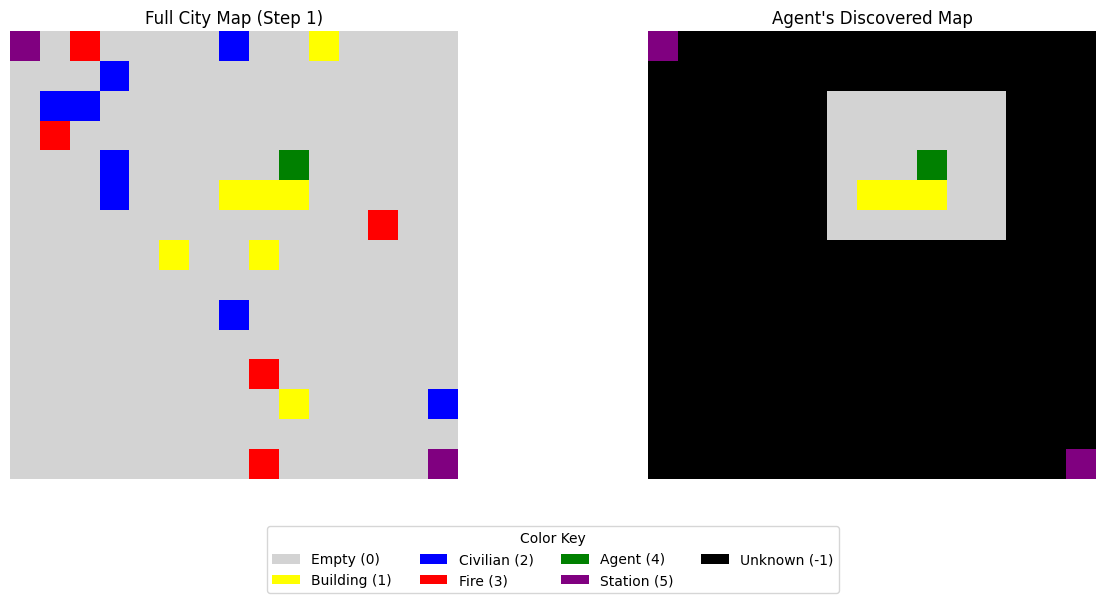

Step 1
LLM Action: move down
Reasoning: To continue exploring downwards and investigate the '1's in the sensor view, which could indicate the presence of civilians or fires.
Invalid action: move down. Choosing fallback action.
Fallback Action: move right


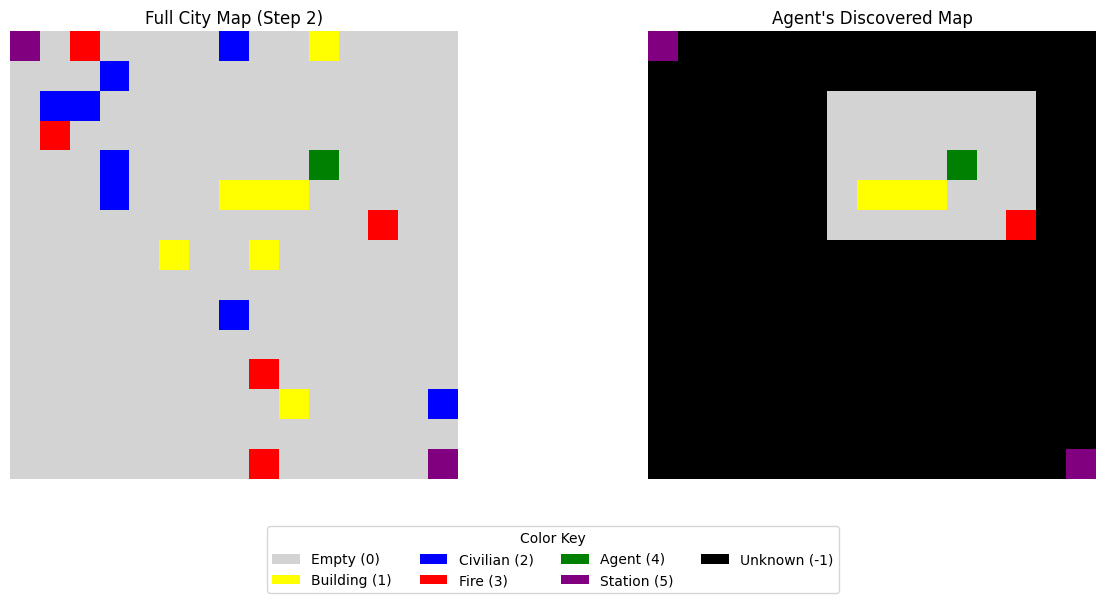

Step 2
LLM Action: move down
Reasoning: To move closer to the fire indicated in the sensor view or gather more information about the environment, potentially positioning the agent to extinguish the fire or find other targets.


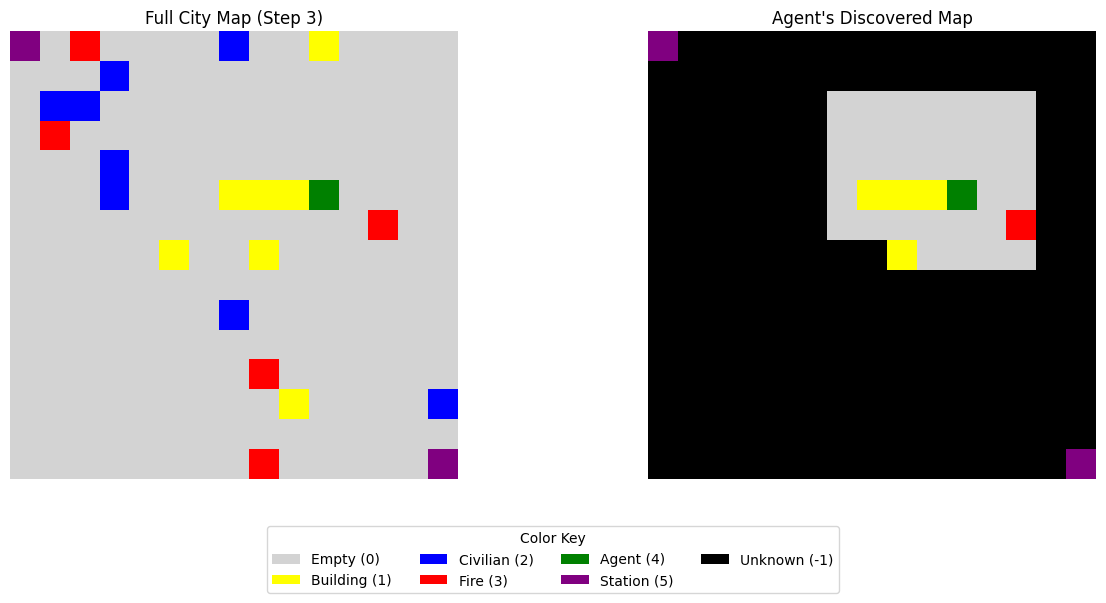

Step 3
LLM Action: move right
Reasoning: To move towards the fire indicated in the sensor view, potentially positioning the agent to extinguish the fire, which aligns with the goal of extinguishing fires.


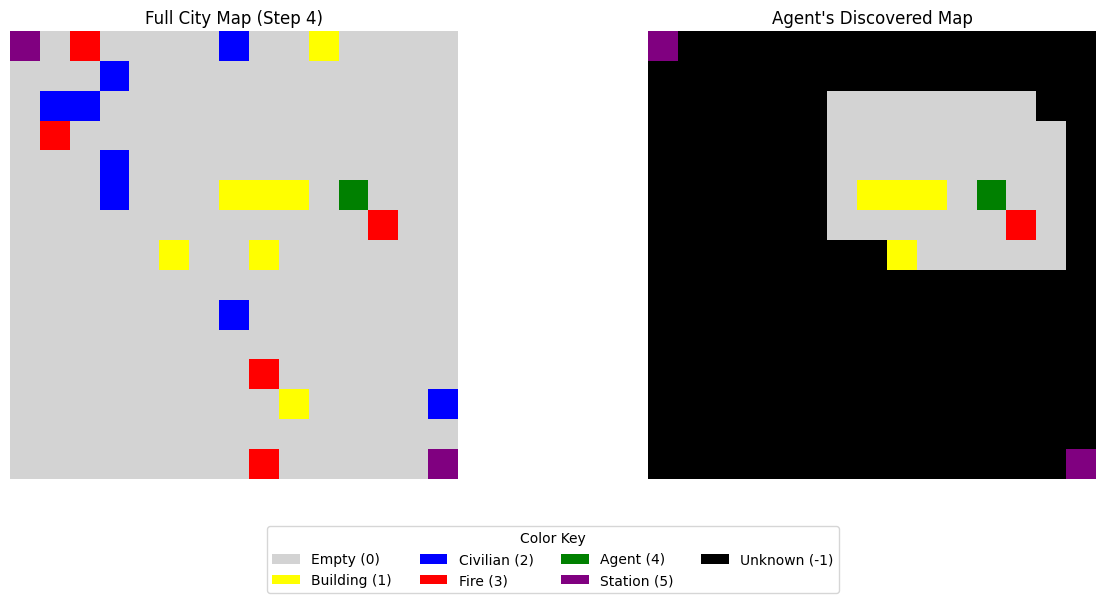

Step 4
LLM Action: move down
Reasoning: To move down and potentially extinguish the fire directly below the agent's current position, aligning with the goal of extinguishing fires.


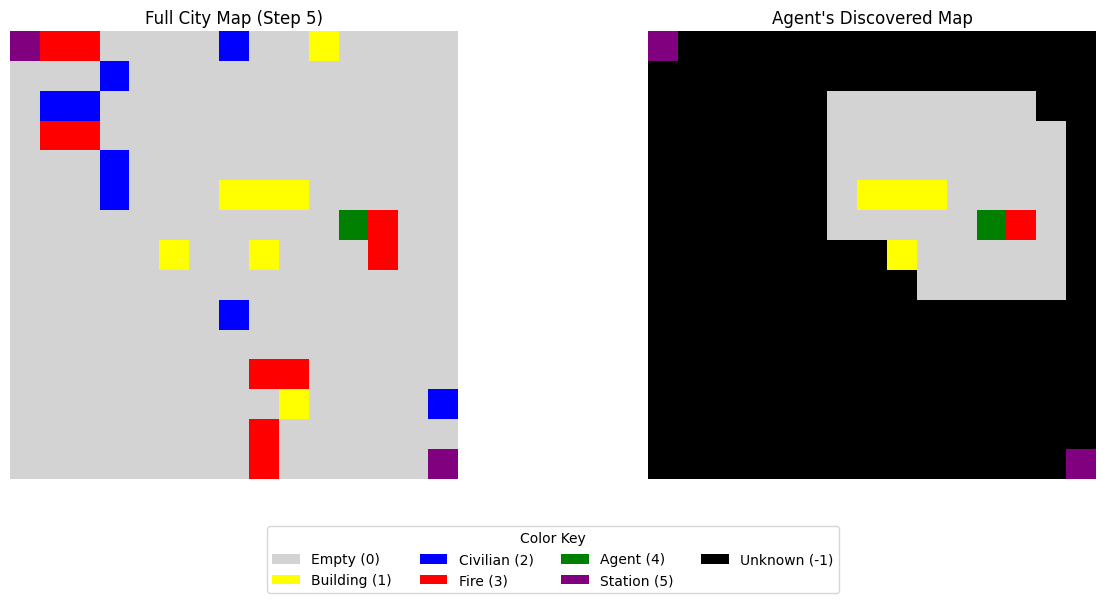

Step 5
LLM Action: move right
Reasoning: To move right and potentially extinguish the fire at position (6, 12), aligning with the goal of extinguishing fires.


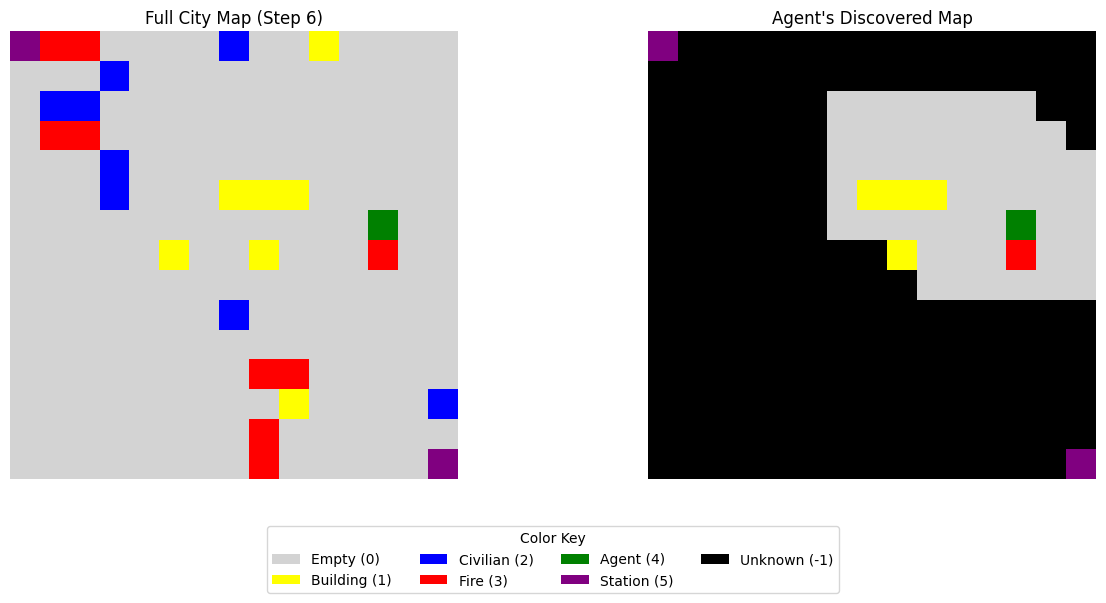

Step 6
LLM Action: extinguish fire
Reasoning: To extinguish the fire at the current position (6, 12), as the last cell content was a fire and this action directly aligns with the goal of extinguishing fires.
Fire extinguished! Score: 10


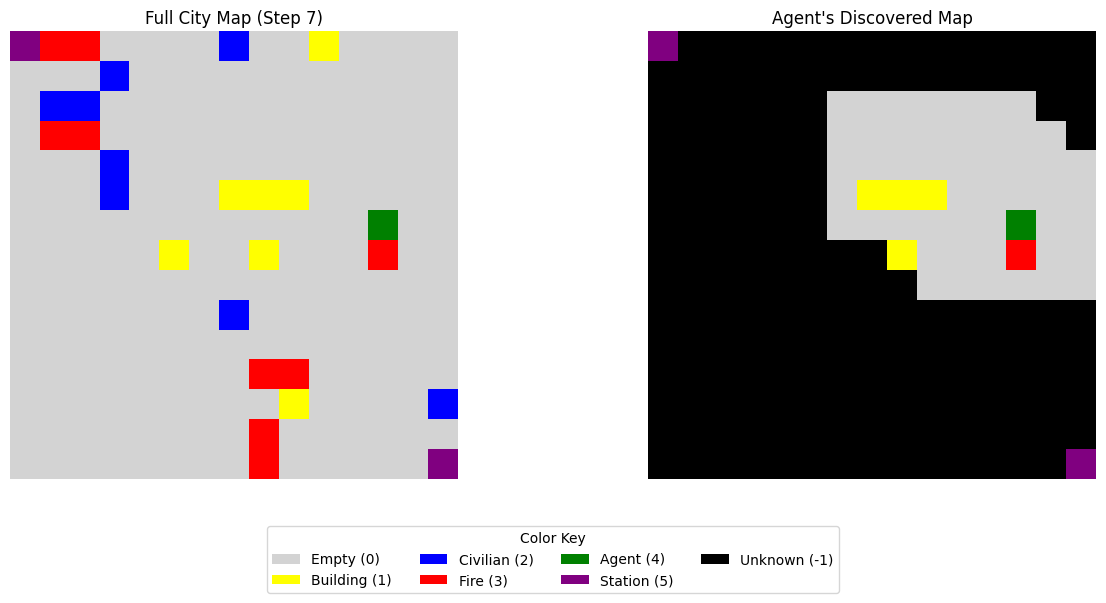

Step 7
LLM Action: move down
Reasoning: To move down towards the known fire at position (7, 12), aligning with the goal of extinguishing fires.


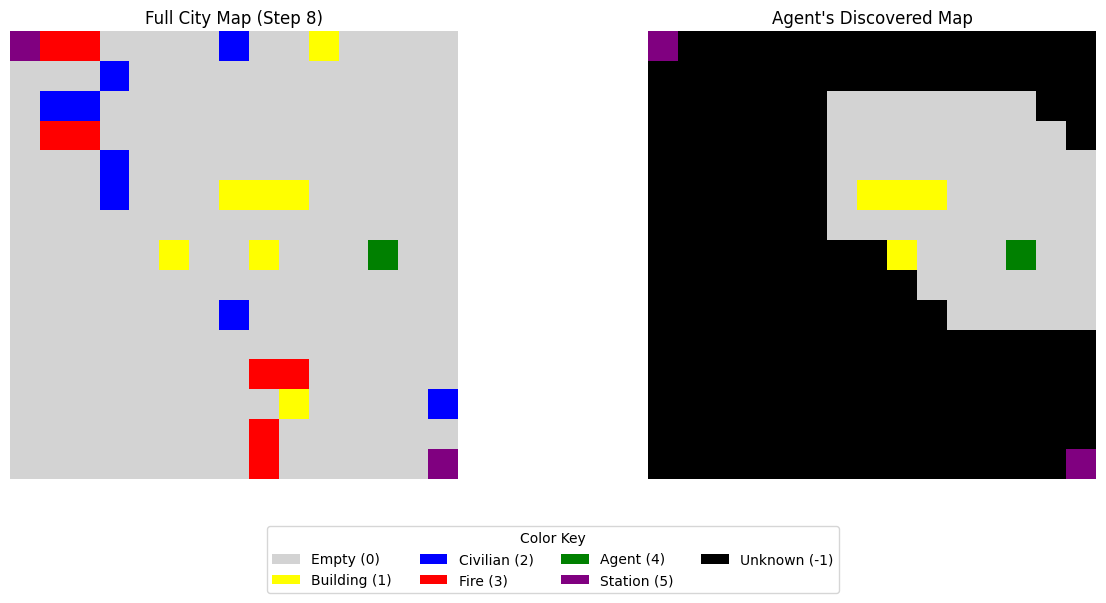

Step 8
LLM Action: extinguish fire
Reasoning: To extinguish the fire at the current position (7, 12), as the last cell content was a fire and this action directly aligns with the goal of extinguishing fires.
Fire extinguished! Score: 20


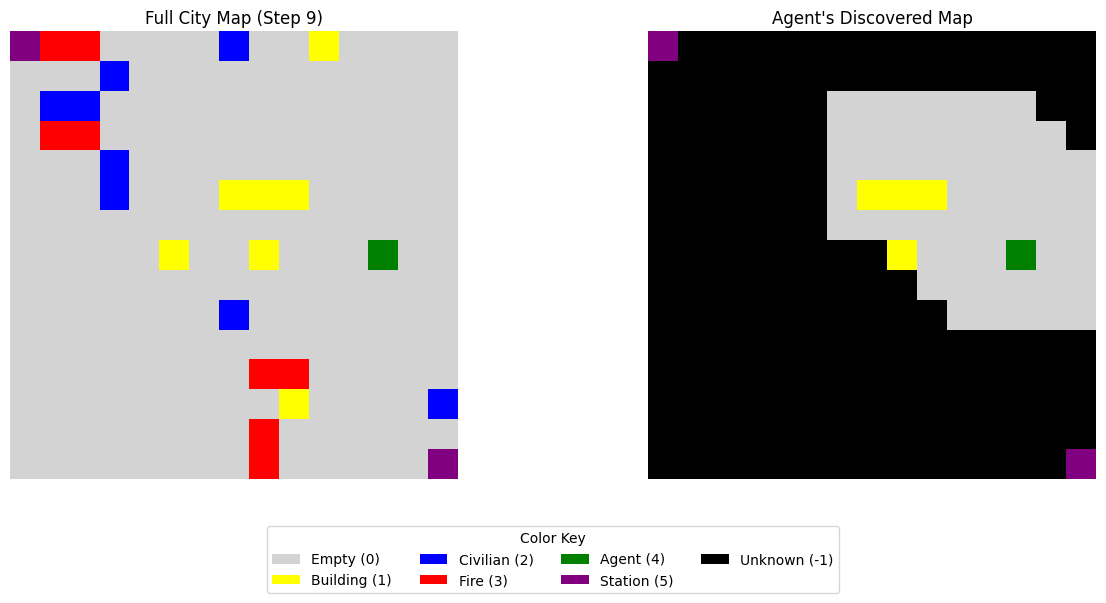

Step 9
LLM Action: move down
Reasoning: To continue exploring the environment, potentially moving closer to the nearest station or discovering new areas that might contain fires or civilians.


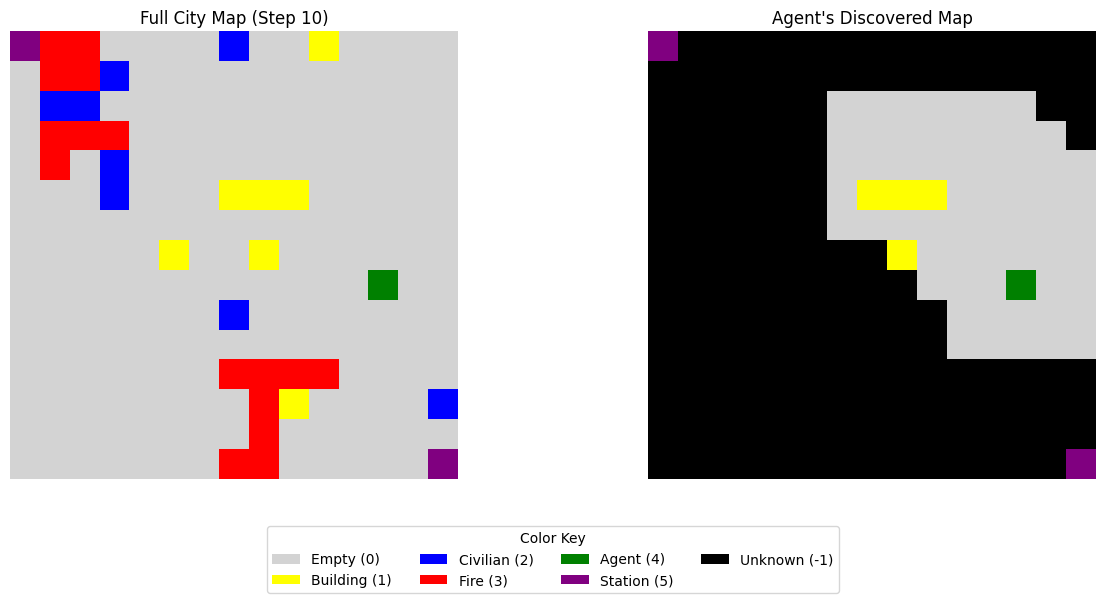

Step 10
LLM Action: move down
Reasoning: To move closer to the nearest station at (14, 14) by decreasing the vertical distance, which might also lead to discovering new areas or potential fires and civilians.


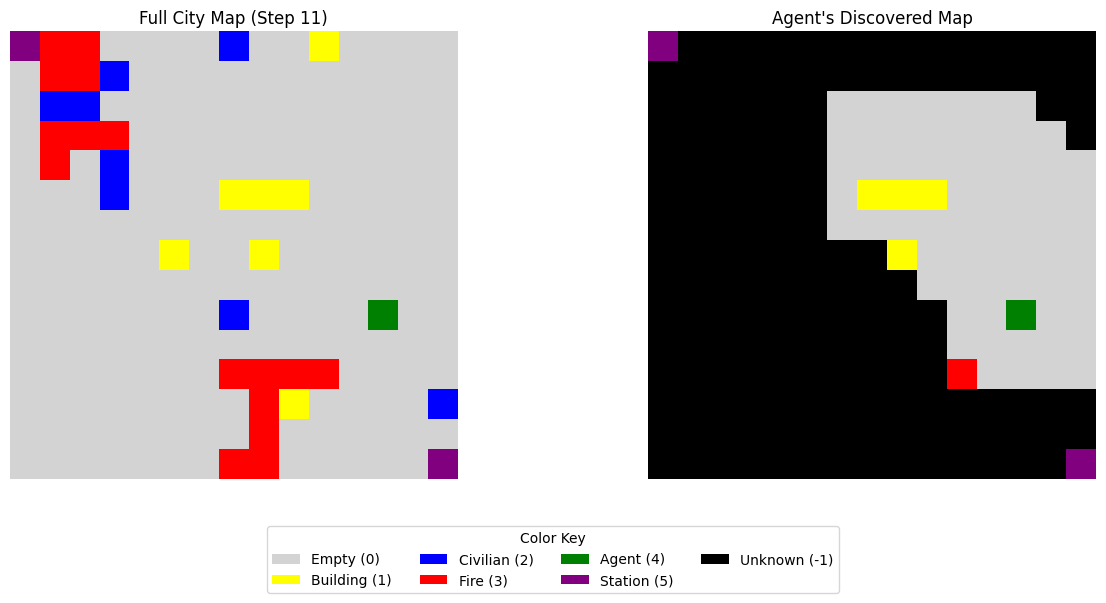

Step 11
LLM Action: move down
Reasoning: To move down and address the fire directly below the agent's current position, as indicated in the sensor view, which is a more immediate concern than the known fire at (11, 10).


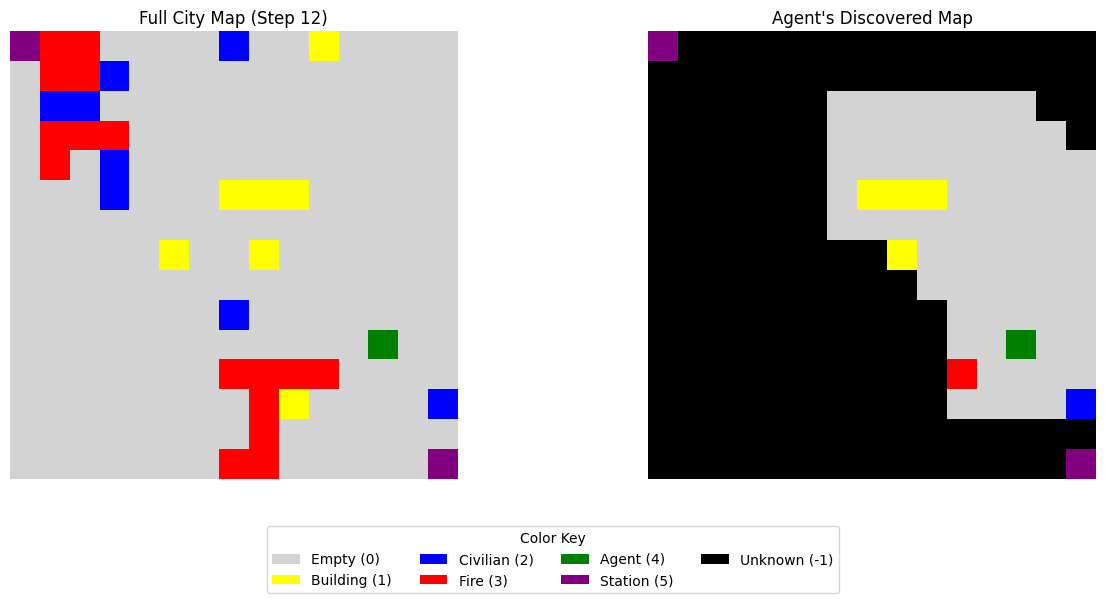

Step 12
LLM Action: move down
Reasoning: To move down towards the civilian in the sensor view, which aligns with the high-priority goal of rescuing civilians and is an immediate opportunity for action.


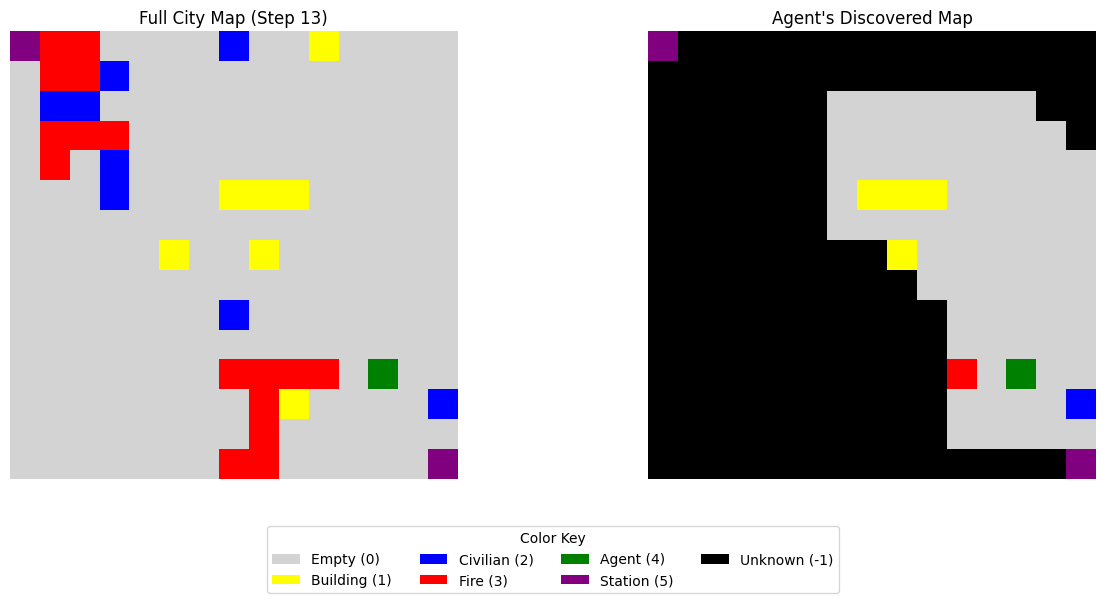

Step 13
LLM Action: move left
Reasoning: To move left and address the known fire at (11, 10), which is directly accessible and aligns with the high-priority goal of extinguishing fires.


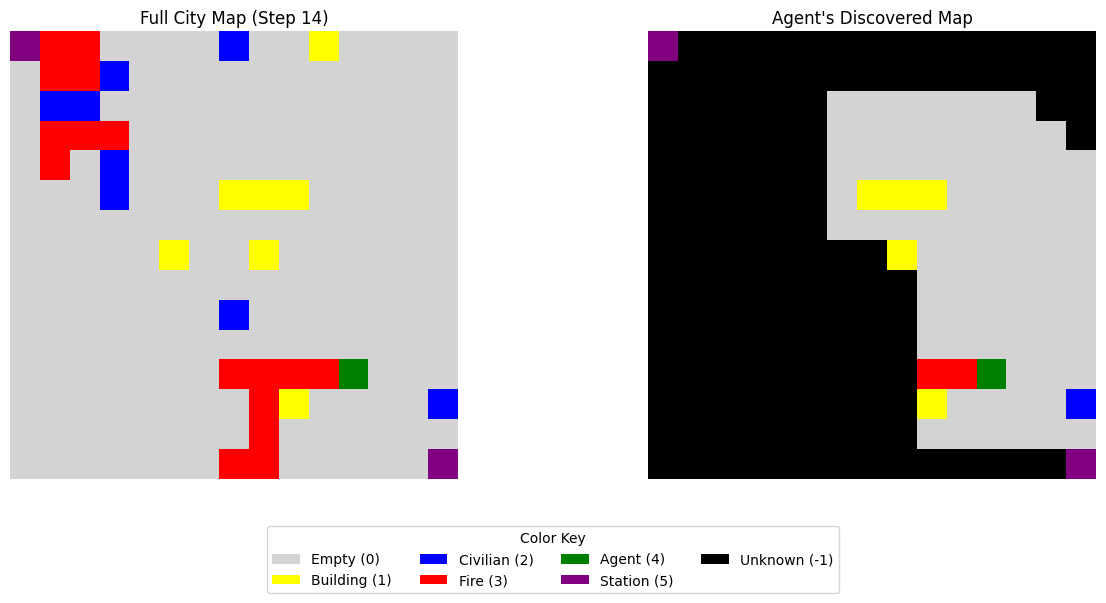

Step 14
LLM Action: move left
Reasoning: To move left and position the agent to extinguish the fire at (11, 10), which is directly adjacent and aligns with the high-priority goal of extinguishing fires.
Civilian died in fire! Score/MQ: -80
Civilian died in fire! Score/MQ: -180


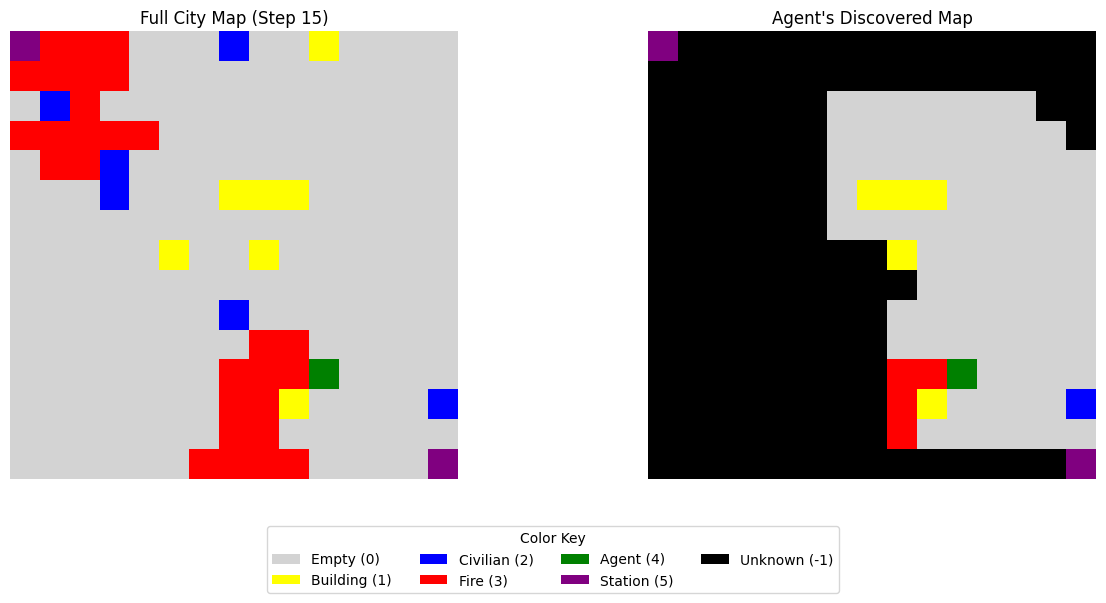

Step 15
LLM Action: extinguish fire
Reasoning: To extinguish the fire at the current position (11, 10), as the last cell content was a fire and this action directly aligns with the goal of extinguishing fires.
Fire extinguished! Score: -170


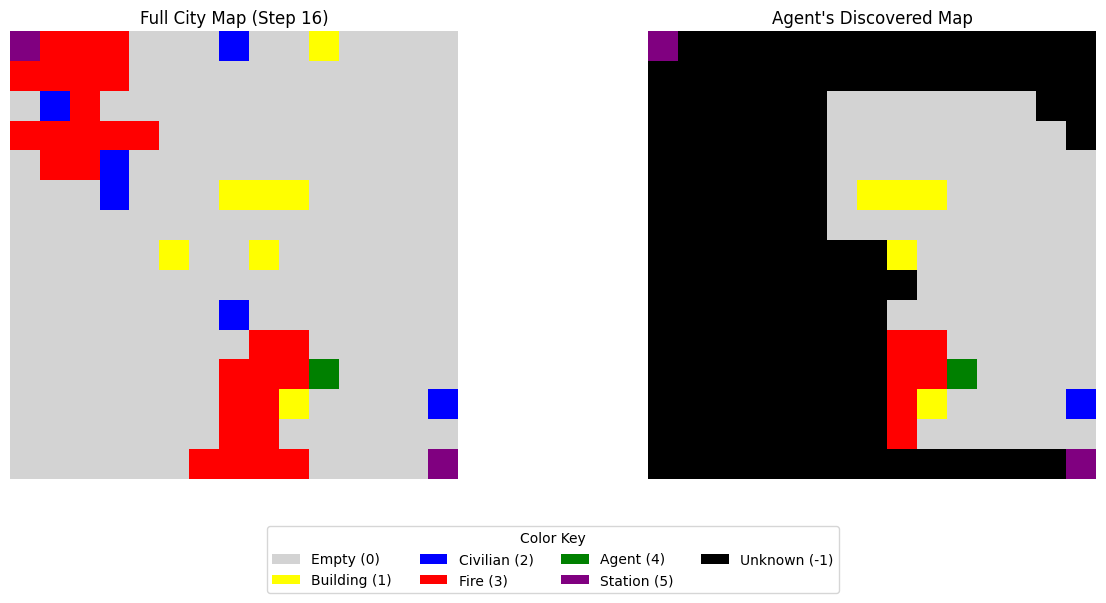

Step 16
LLM Action: move left
Reasoning: To move left and position the agent to extinguish the fire at (11, 9), which is directly adjacent and aligns with the high-priority goal of extinguishing fires.


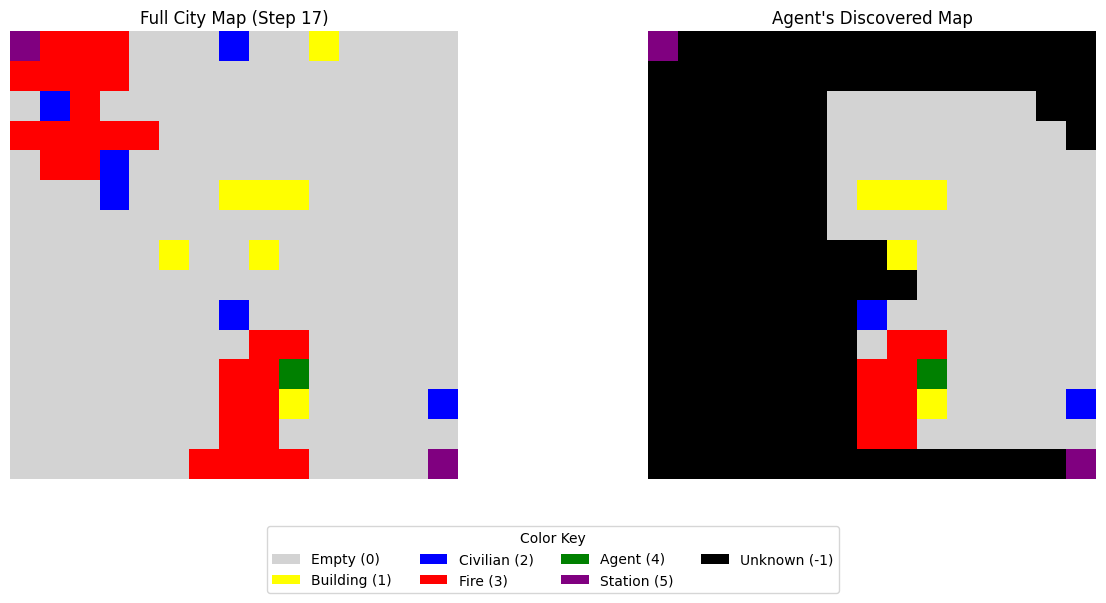

Step 17
LLM Action: extinguish fire
Reasoning: To extinguish the fire at the current position (11, 9), as the last cell content was a fire and this action directly aligns with the goal of extinguishing fires.
Fire extinguished! Score: -160


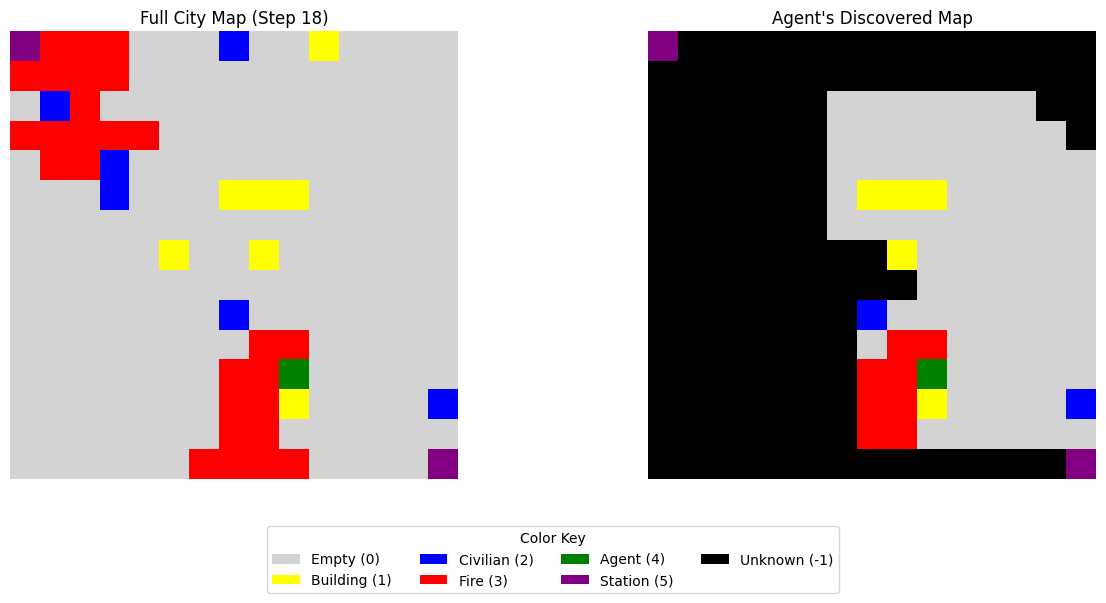

Step 18
LLM Action: move left
Reasoning: To move left and position the agent to extinguish the fire at (11, 8), which is directly adjacent and aligns with the high-priority goal of extinguishing fires.


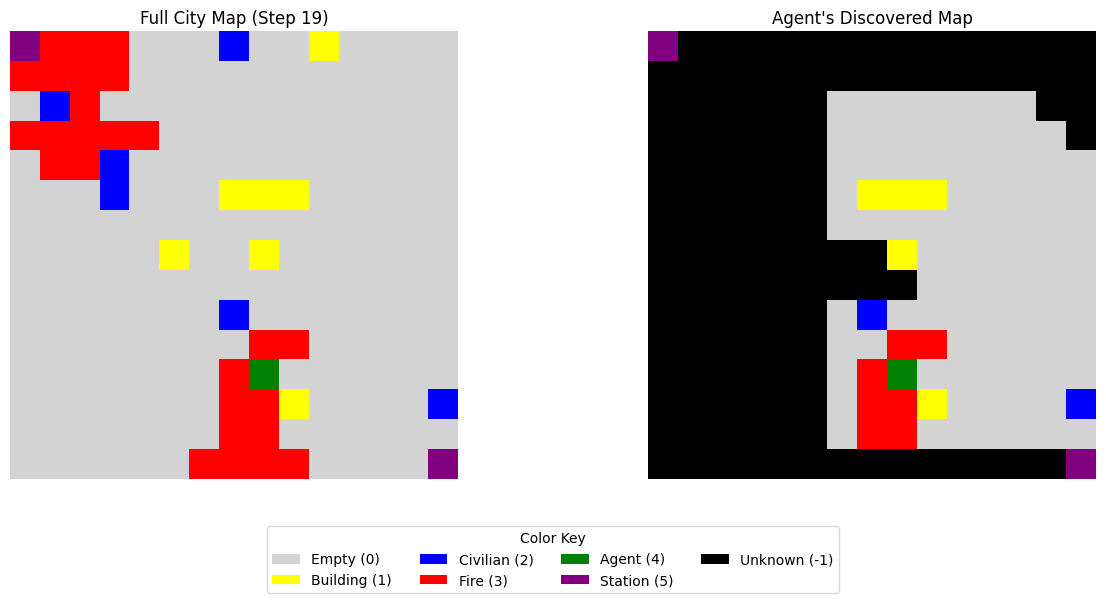

Step 19
LLM Action: extinguish fire
Reasoning: To extinguish the fire at the current position (11, 8), as the last cell content was a fire and this action directly aligns with the goal of extinguishing fires.
Fire extinguished! Score: -150
Civilian died in fire! Score/MQ: -250
Civilian died in fire! Score/MQ: -350


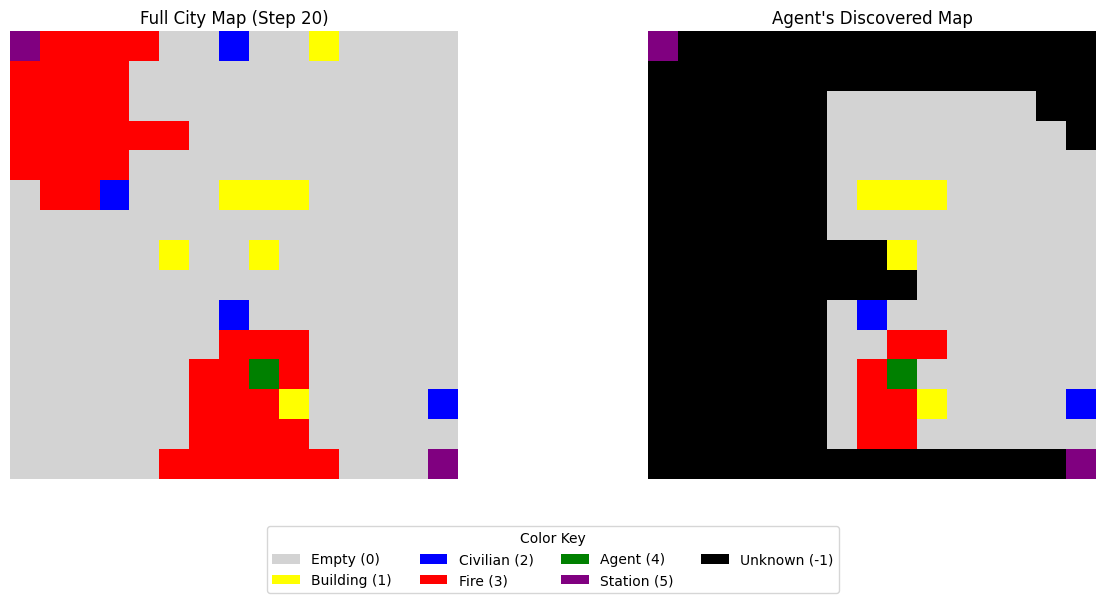

Step 20
LLM Action: move left
Reasoning: To move left and position the agent to extinguish the fire at (11, 7), which is directly adjacent and aligns with the high-priority goal of extinguishing fires.


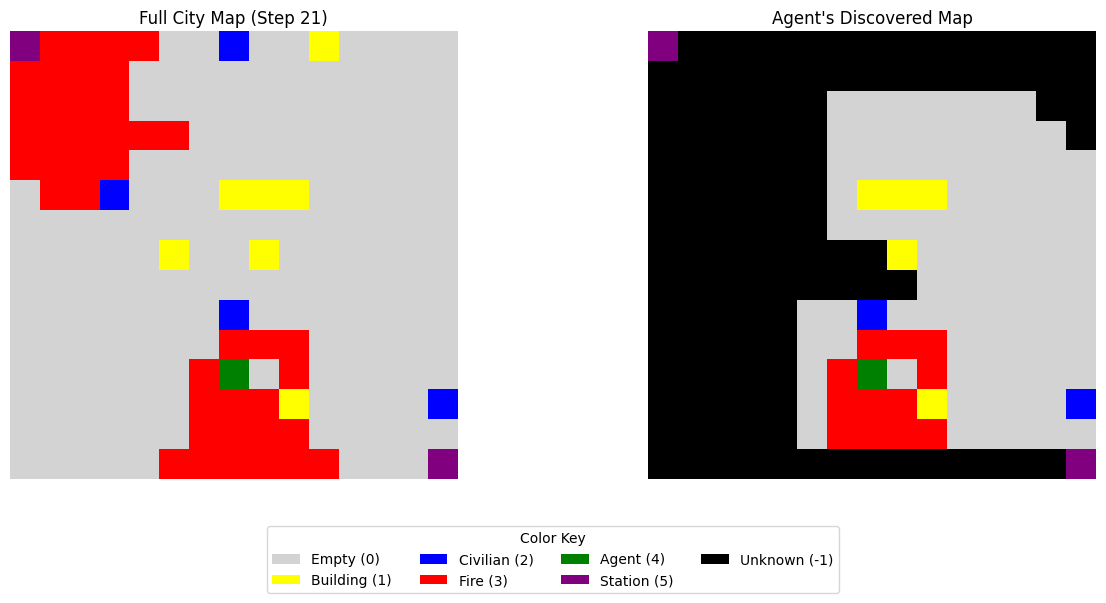

Step 21
LLM Action: extinguish fire
Reasoning: To extinguish the fire at the current position (11, 7), as the last cell content was a fire and this action directly aligns with the goal of extinguishing fires.
Fire extinguished! Score: -340


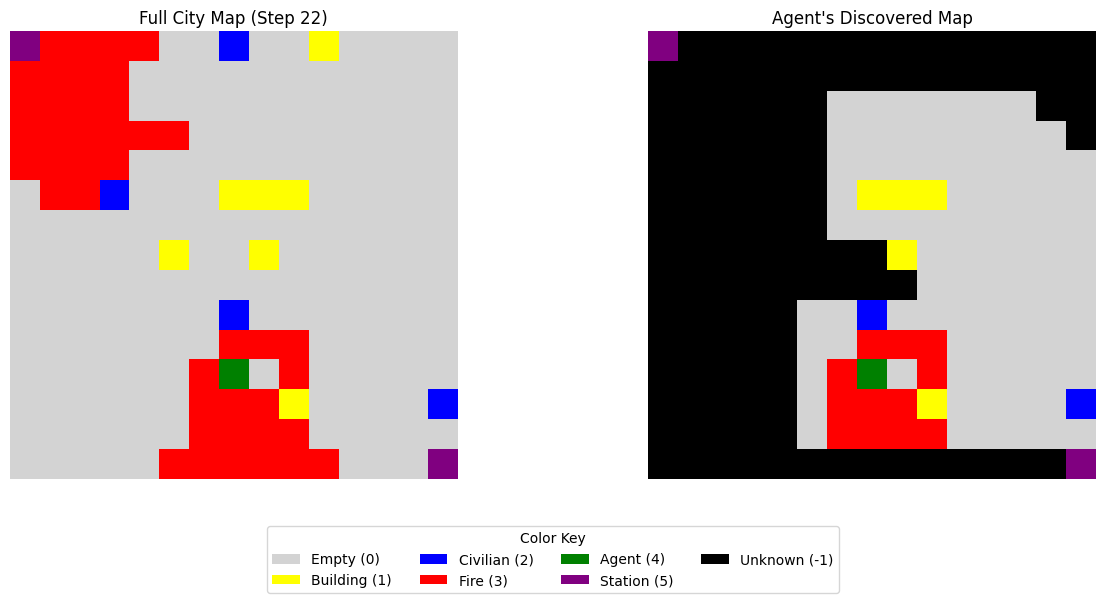

Step 22
LLM Action: move up
Reasoning: To move up and position the agent to rescue the civilian at (9, 7), which is closer and aligns with the high-priority goal of rescuing civilians.


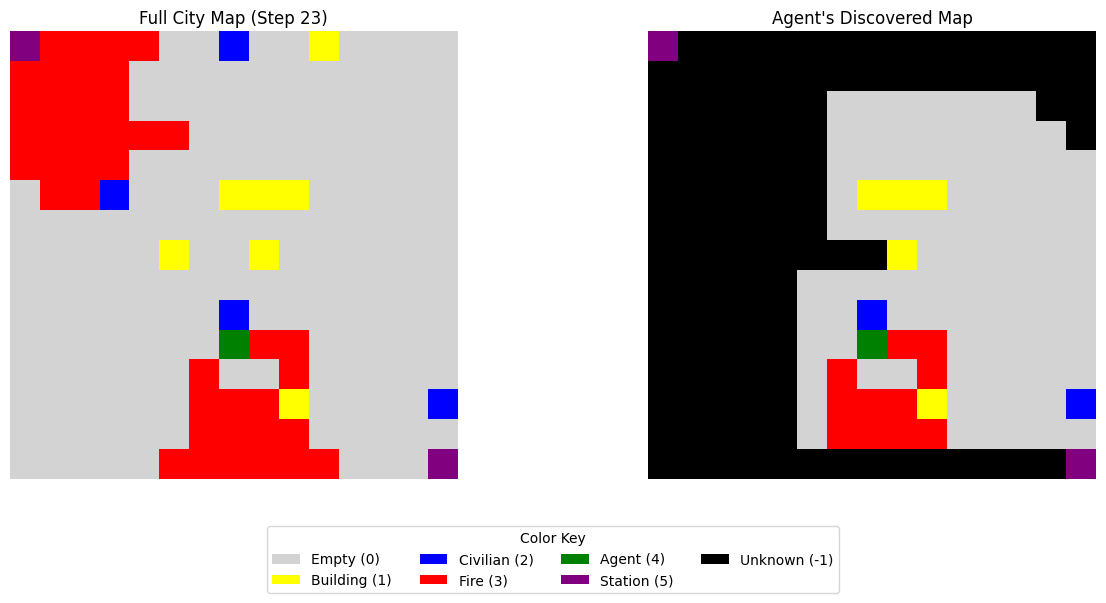

Step 23
LLM Action: move up
Reasoning: To move up and rescue the civilian at (9, 7), as the agent is next to the civilian and this action directly aligns with the goal of rescuing civilians.


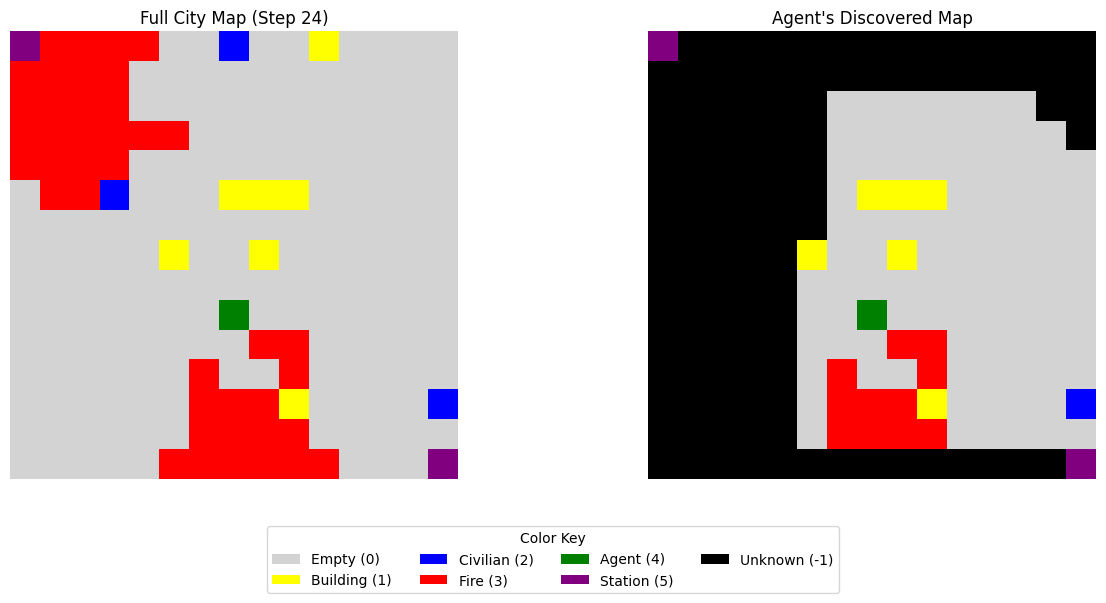

Step 24
LLM Action: rescue civilian
Reasoning: To rescue the civilian at the current position (9, 7), as the last cell content was a civilian and this action directly aligns with the goal of rescuing civilians.
Civilian picked up!
Civilian died in fire! Score/MQ: -440


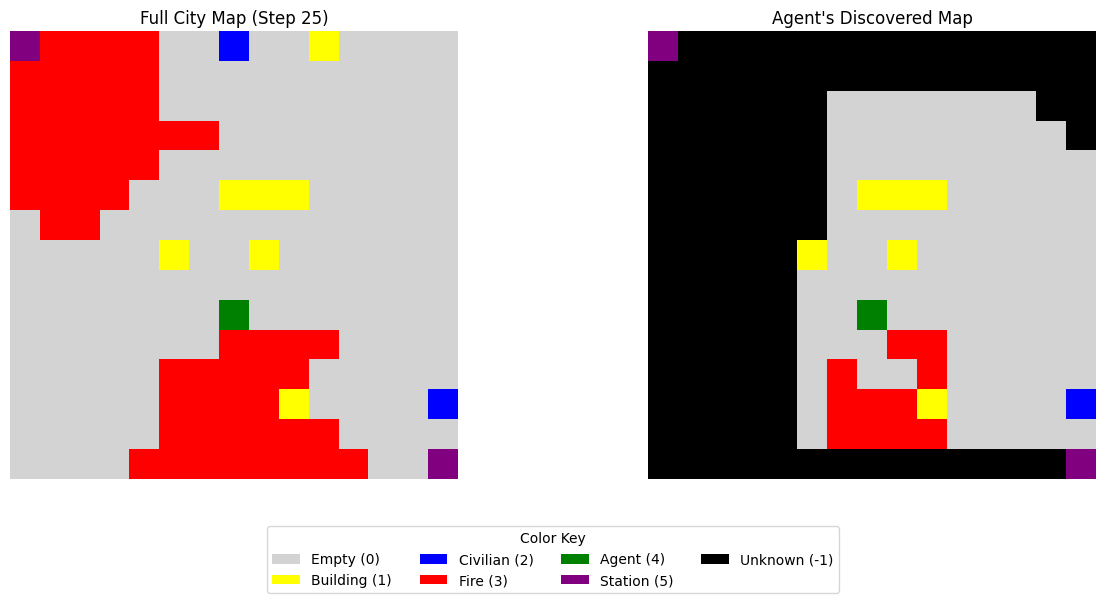

Step 25
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


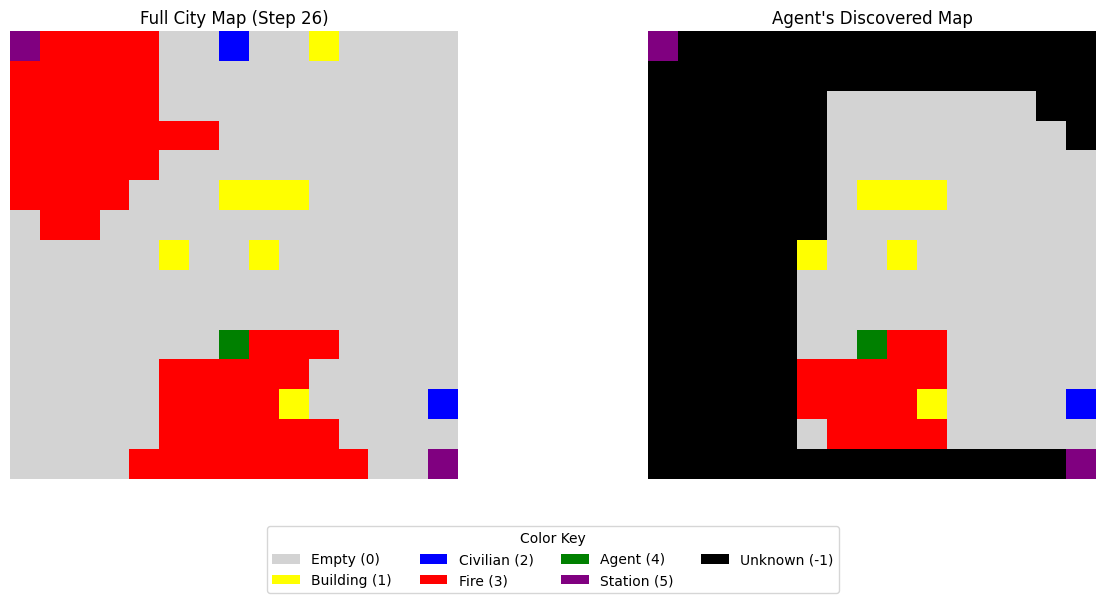

Step 26
LLM Action: move right
Reasoning: To move right towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


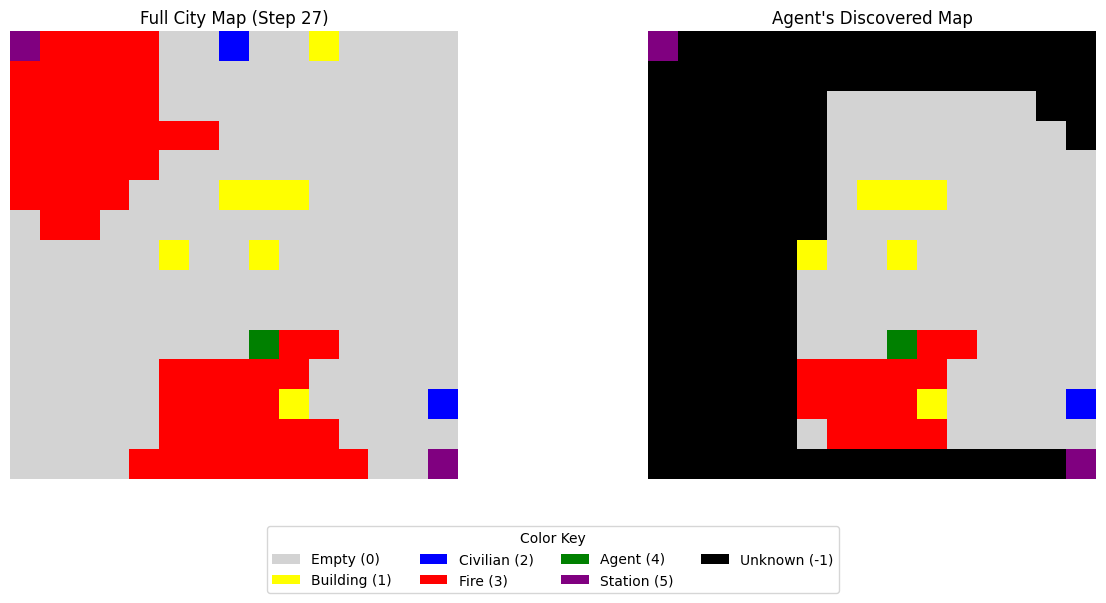

Step 27
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


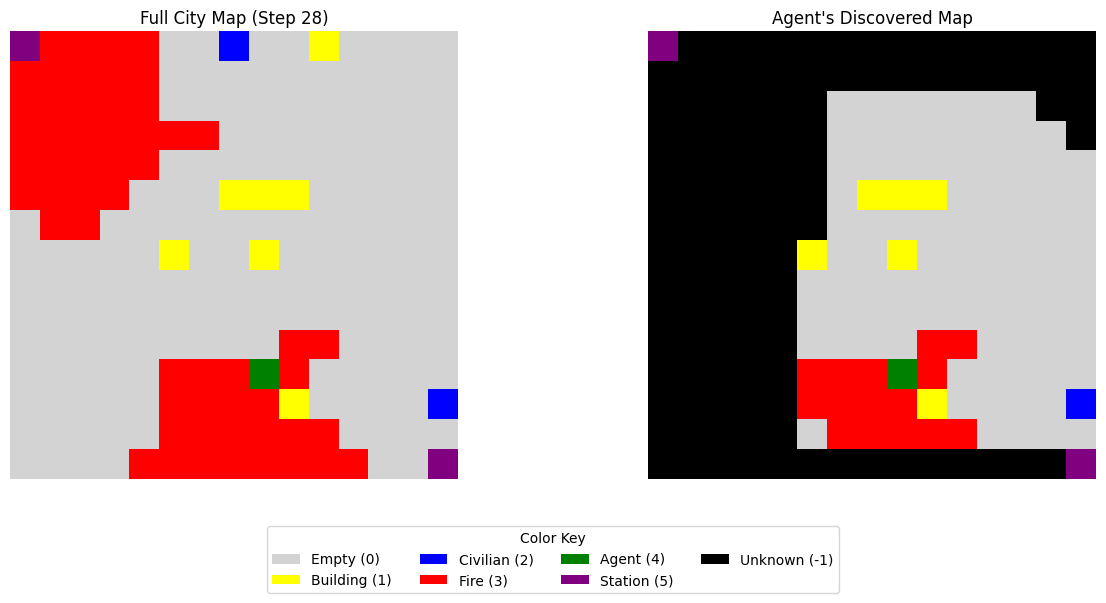

Step 28
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


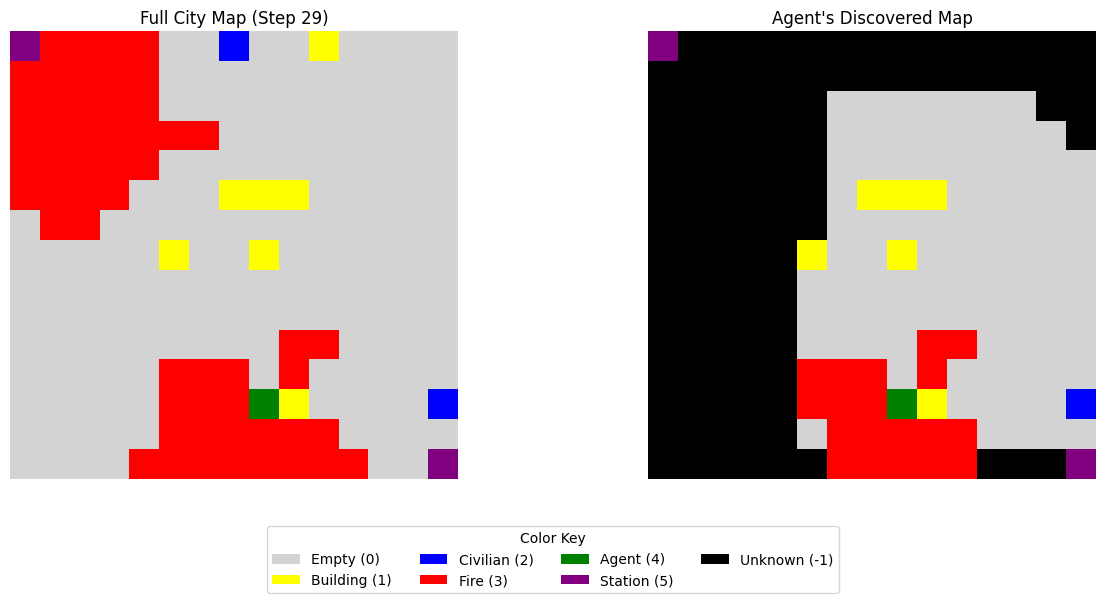

Step 29
LLM Action: move right
Reasoning: To move right towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move right. Choosing fallback action.
Fallback Action: move left


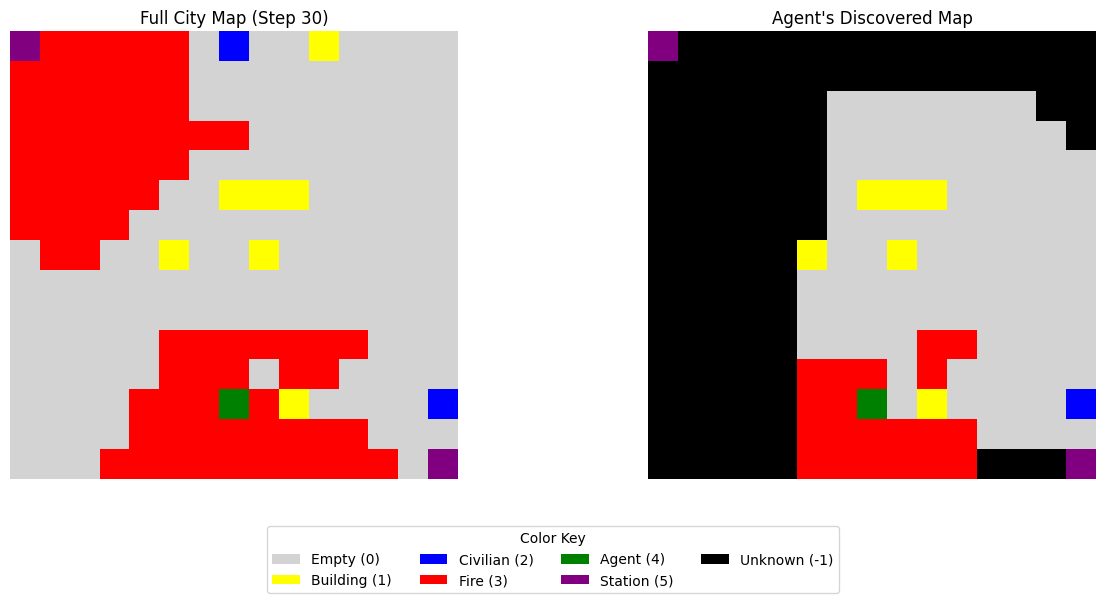

Step 30
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


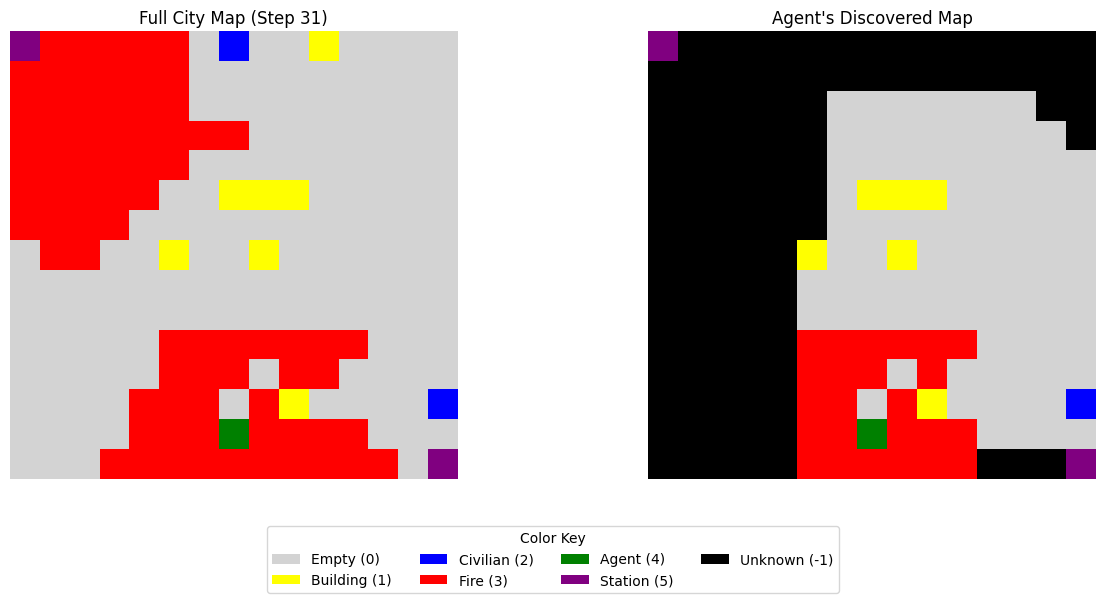

Step 31
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


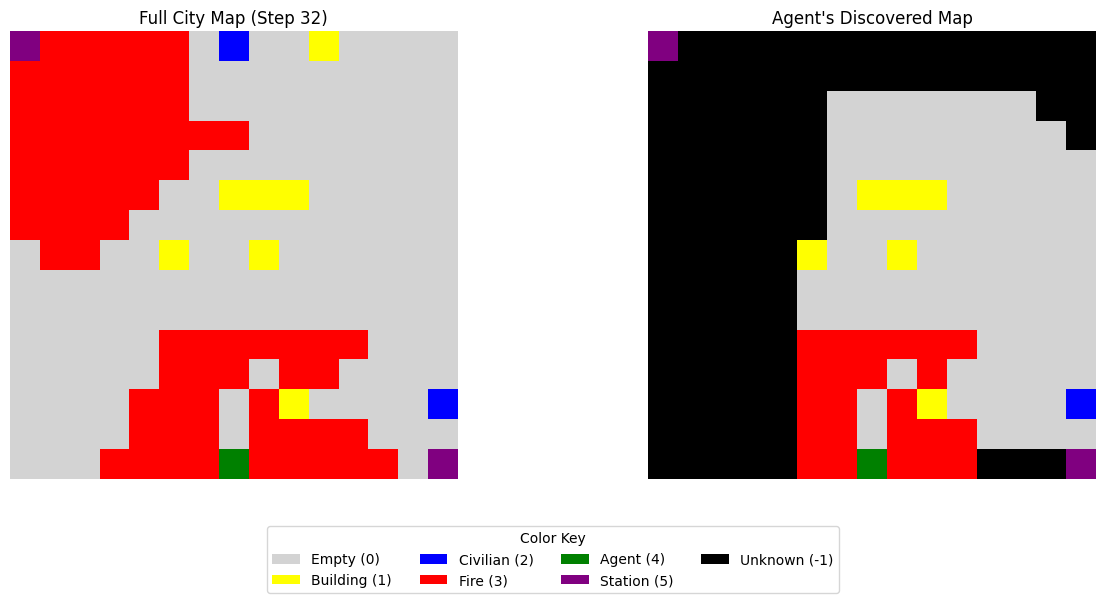

Step 32
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move right


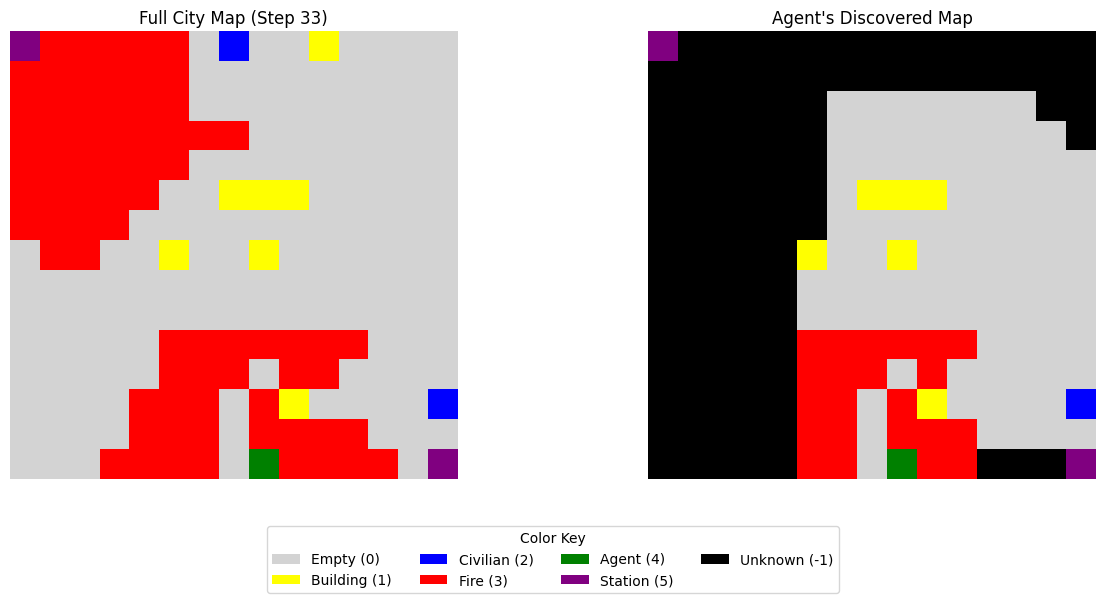

Step 33
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move right


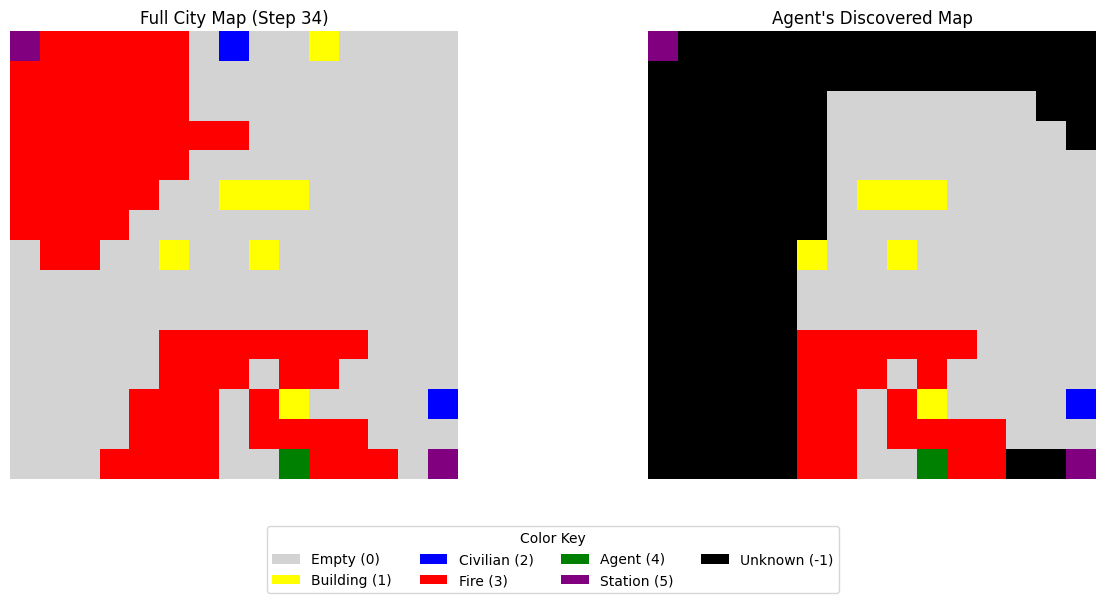

Step 34
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move left


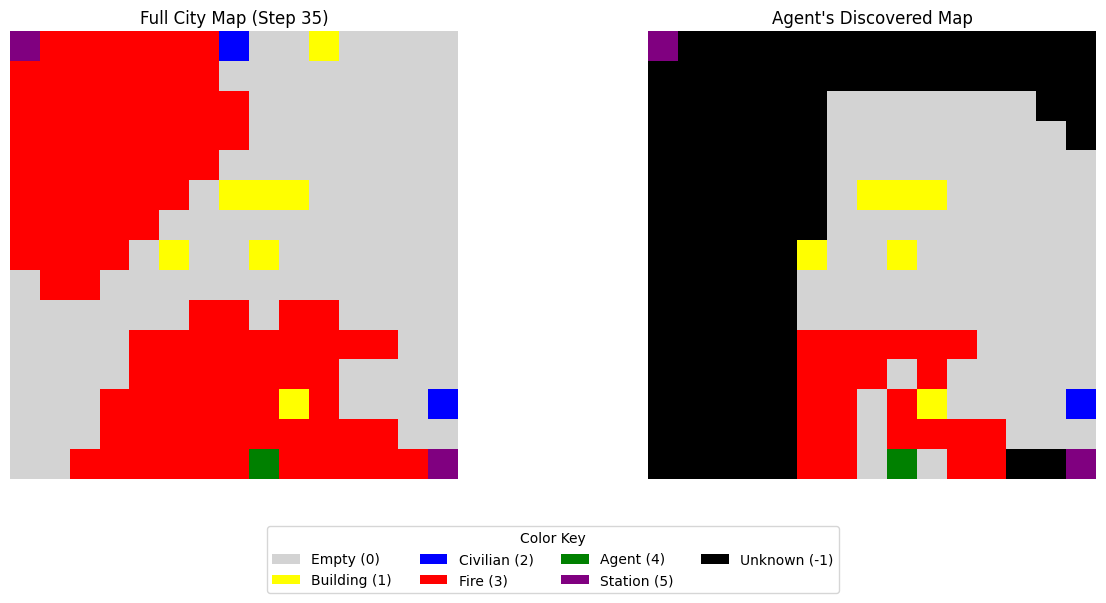

Step 35
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move left


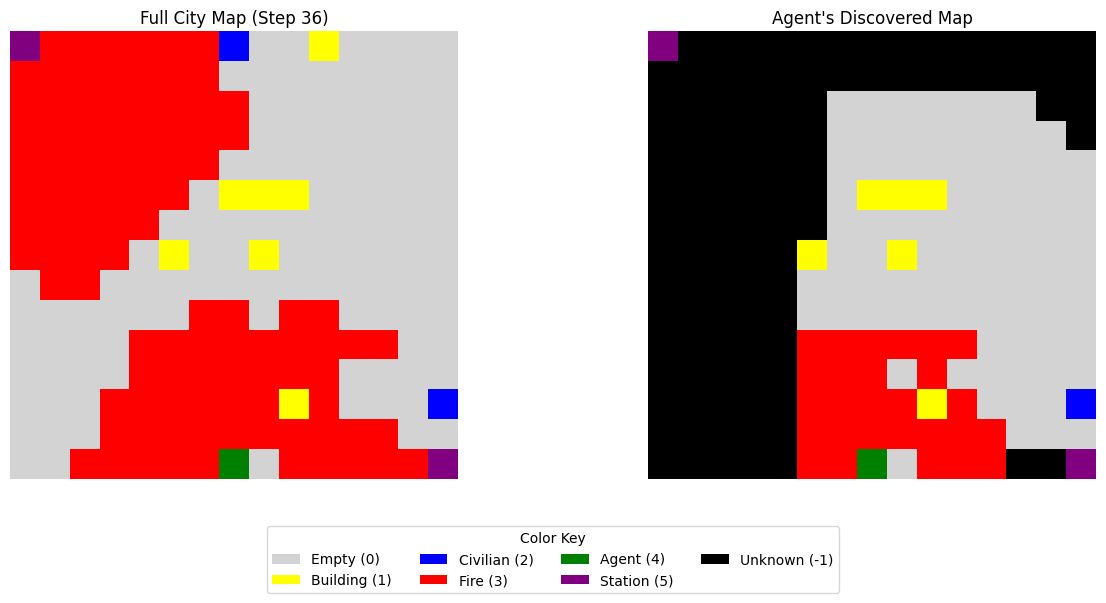

Step 36
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move left


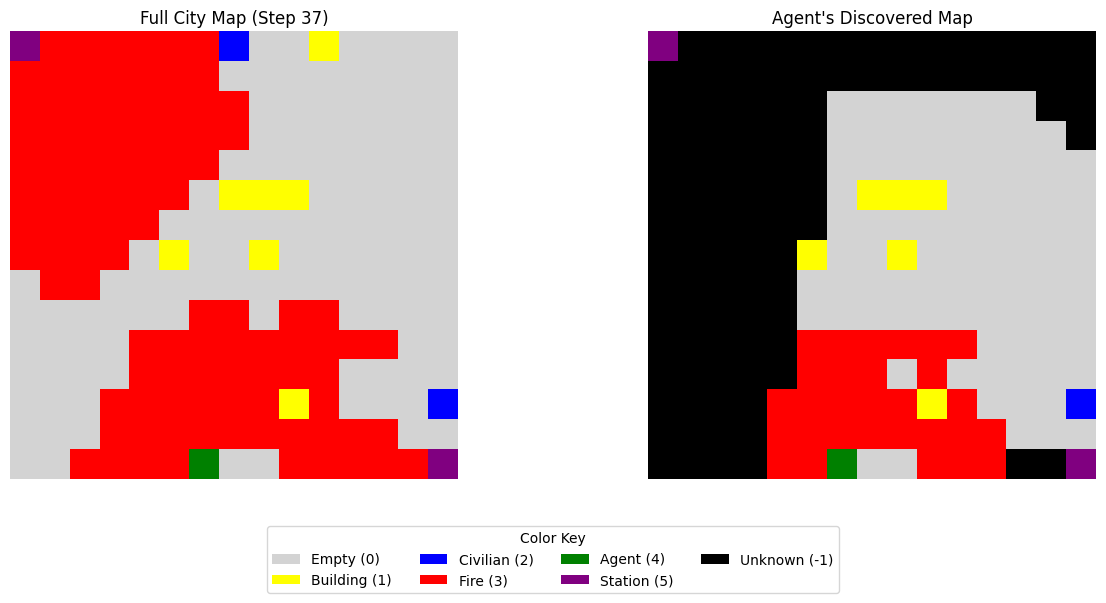

Step 37
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move right


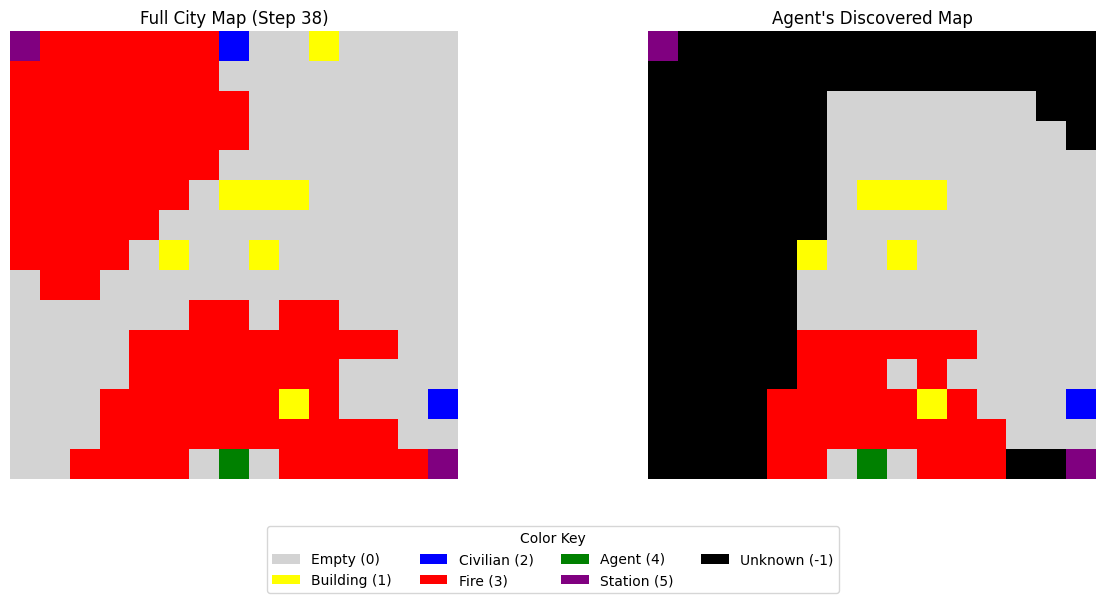

Step 38
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move left


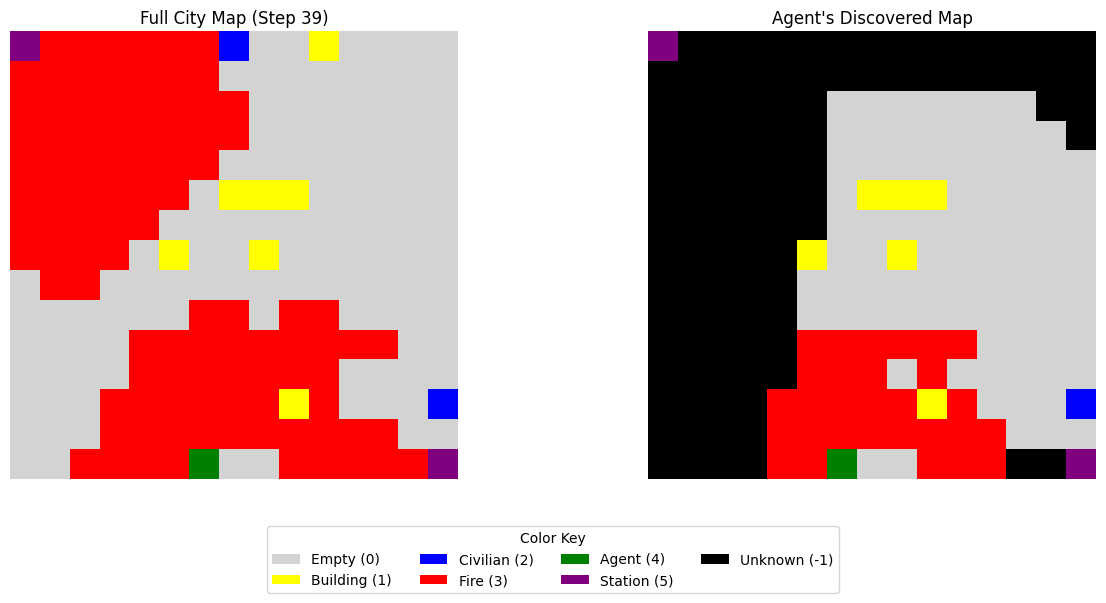

Step 39
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move up
Civilian died in fire! Score/MQ: -540


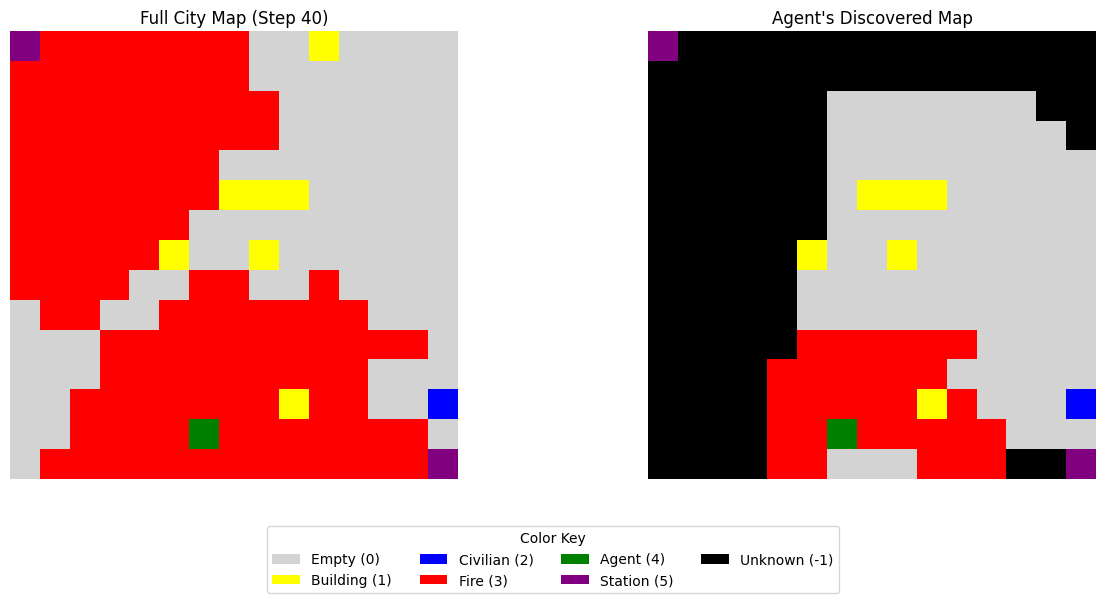

Step 40
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


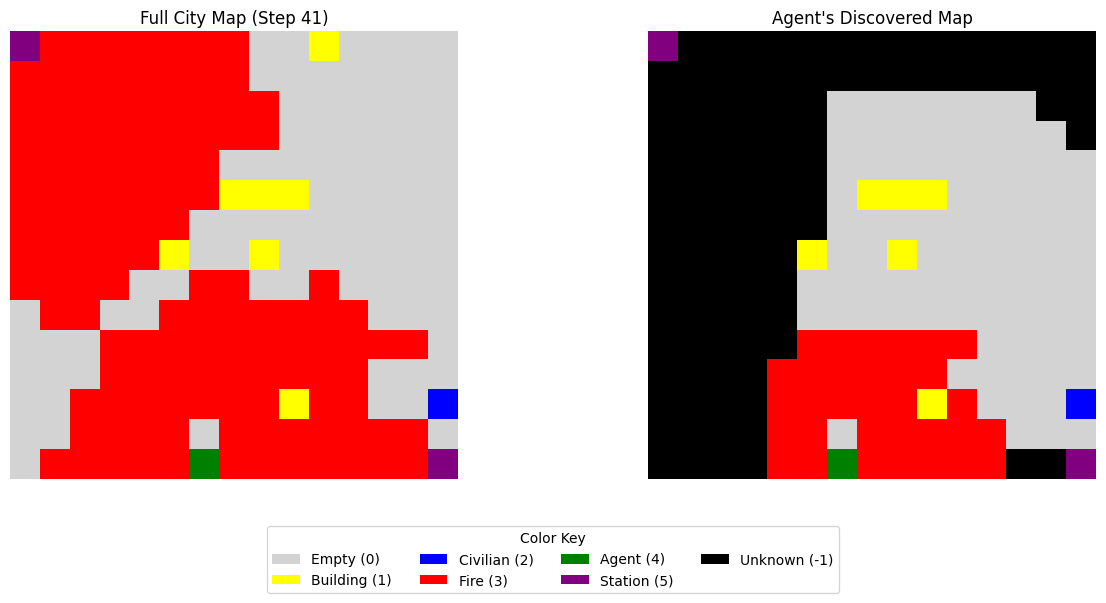

Step 41
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move up


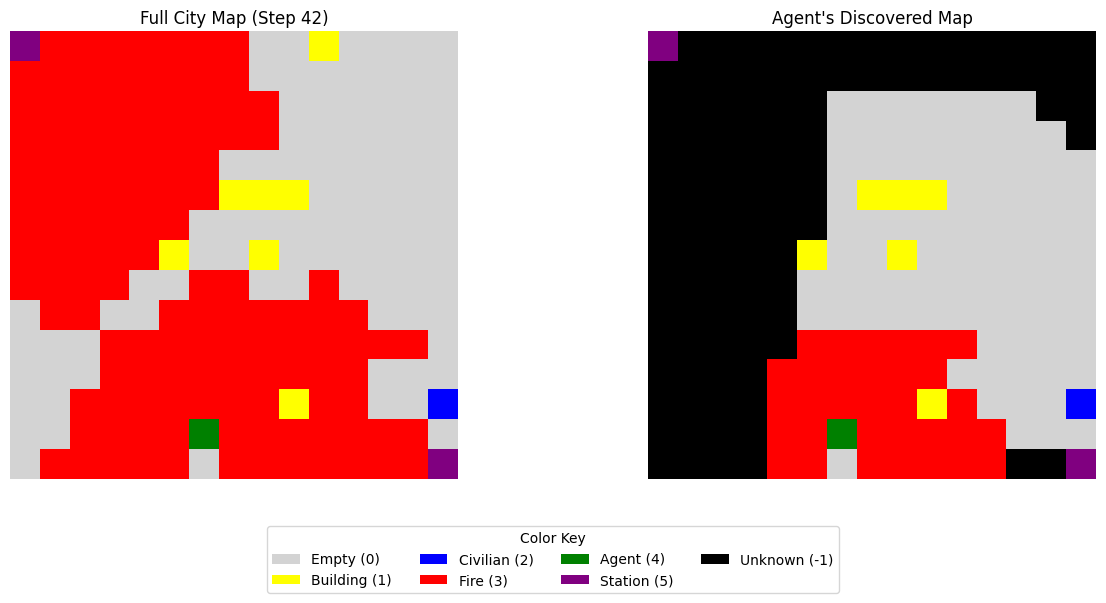

Step 42
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


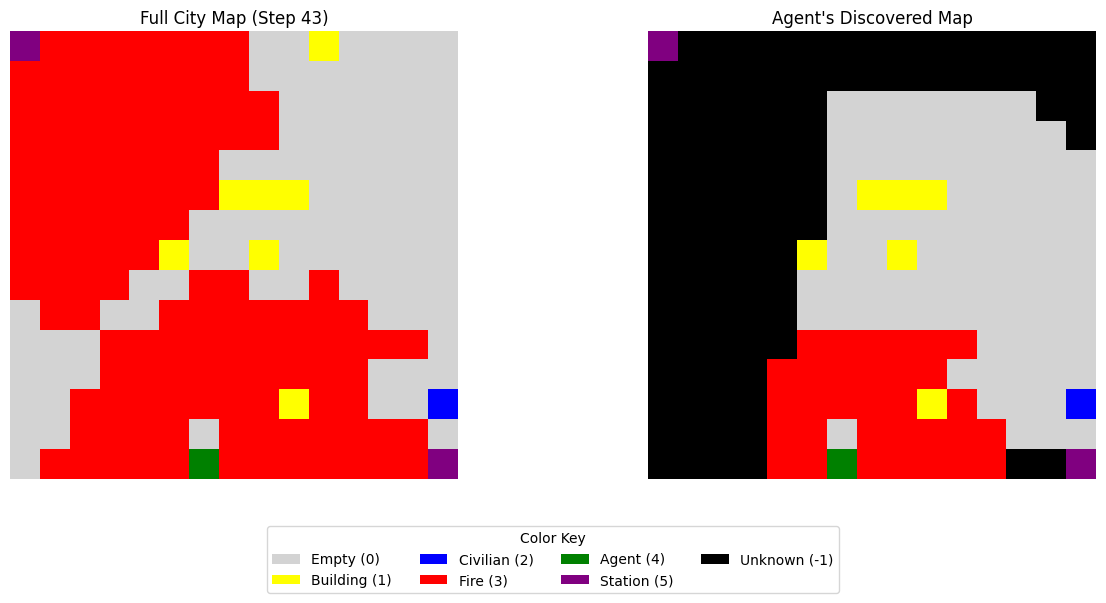

Step 43
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move right


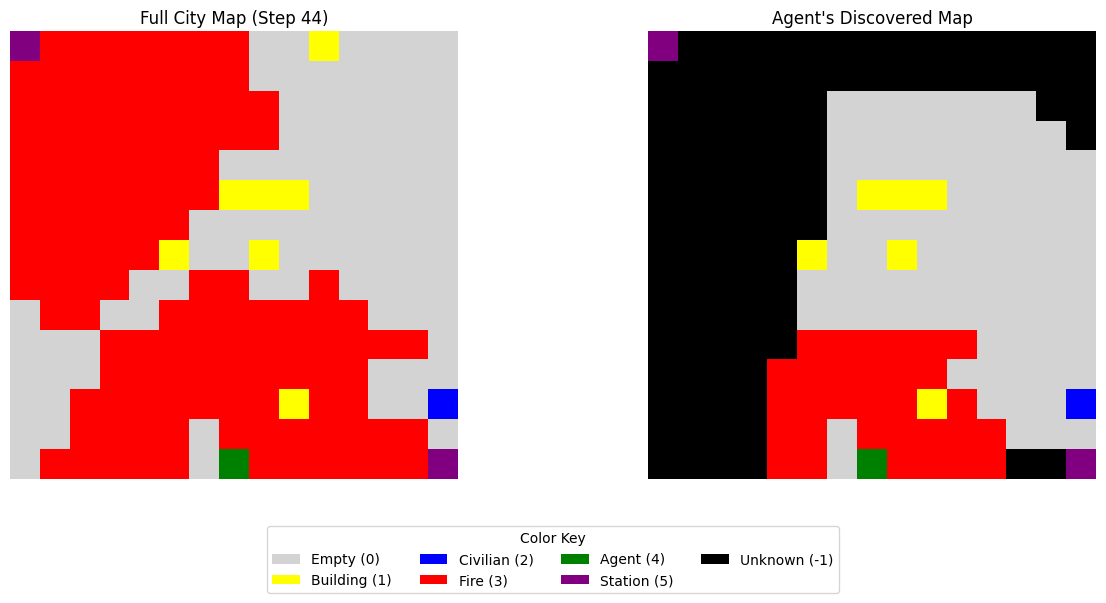

Step 44
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move right


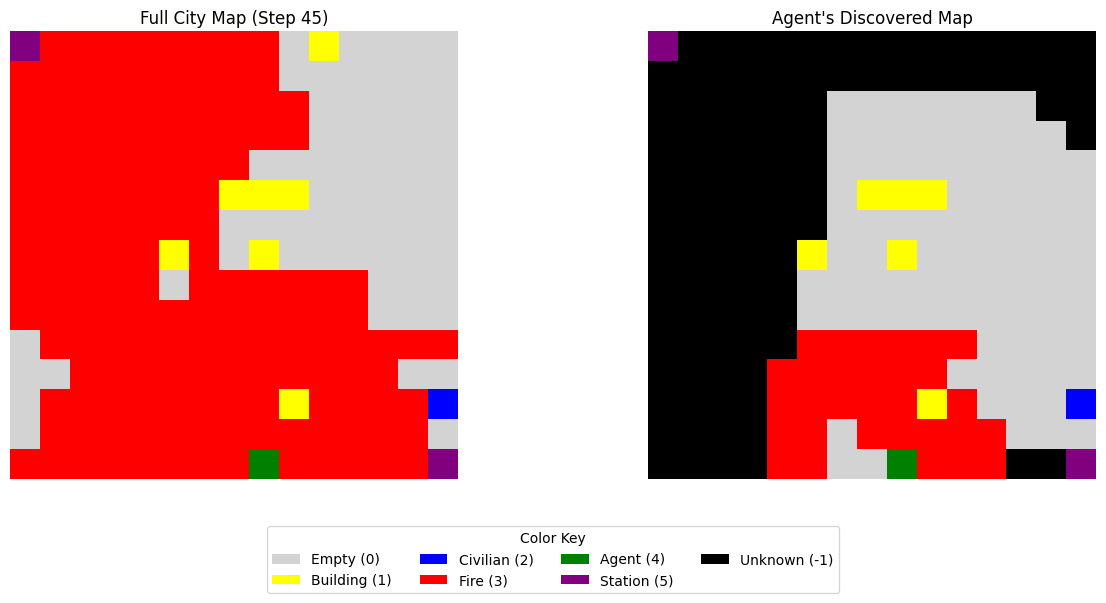

Step 45
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move up


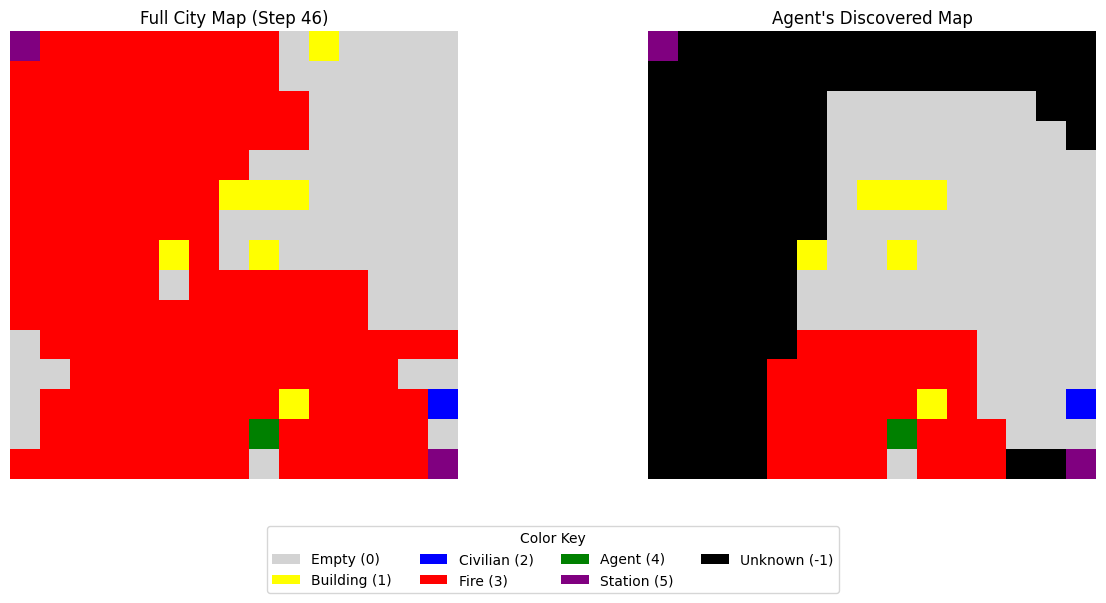

Step 46
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


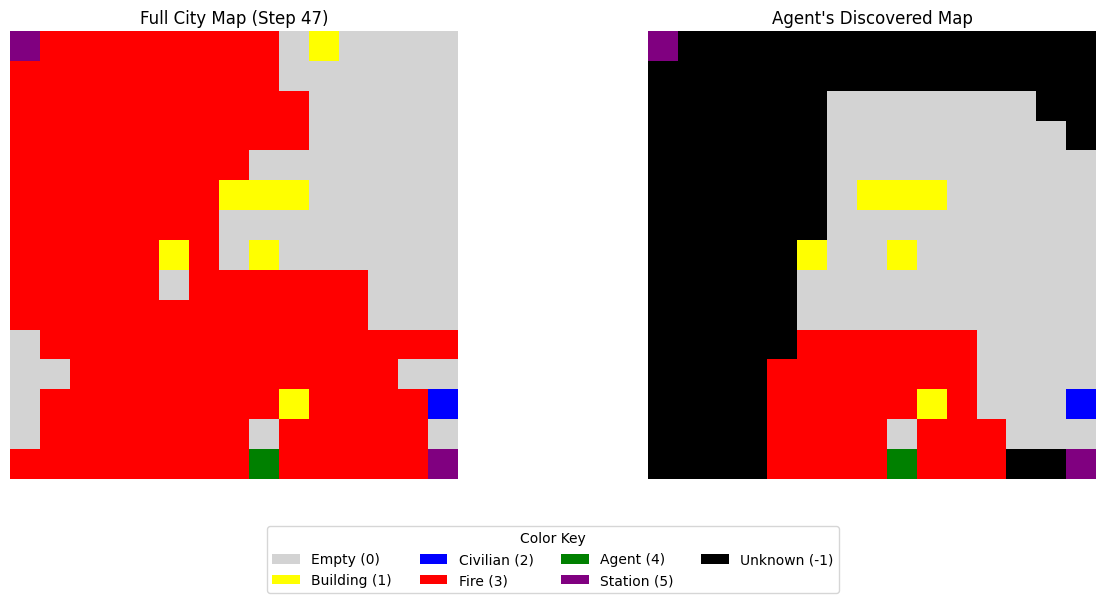

Step 47
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move right


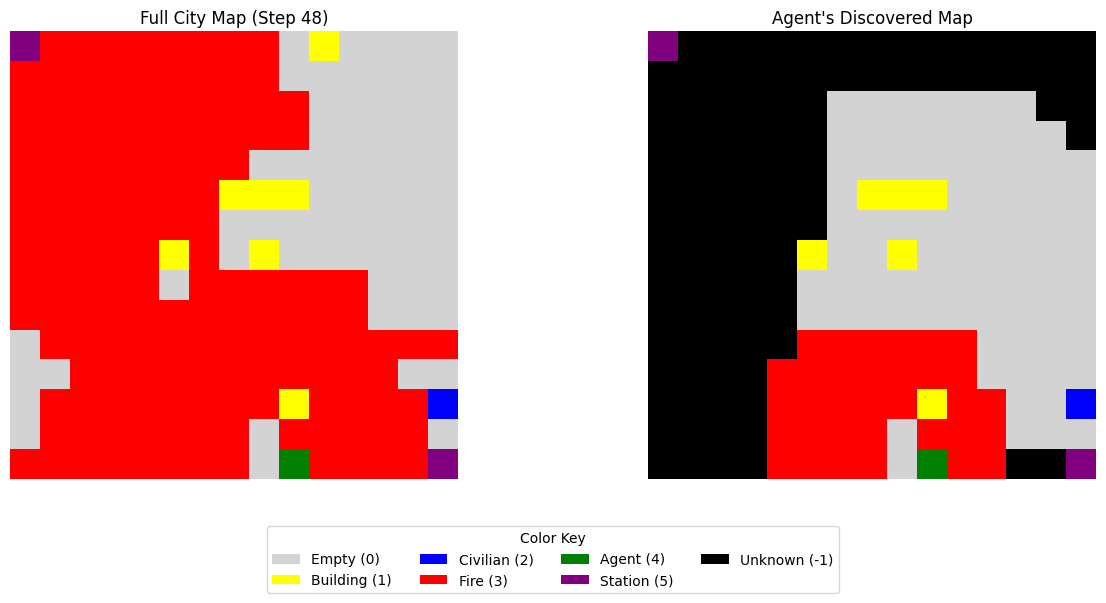

Step 48
LLM Action: move right
Reasoning: To move right towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.


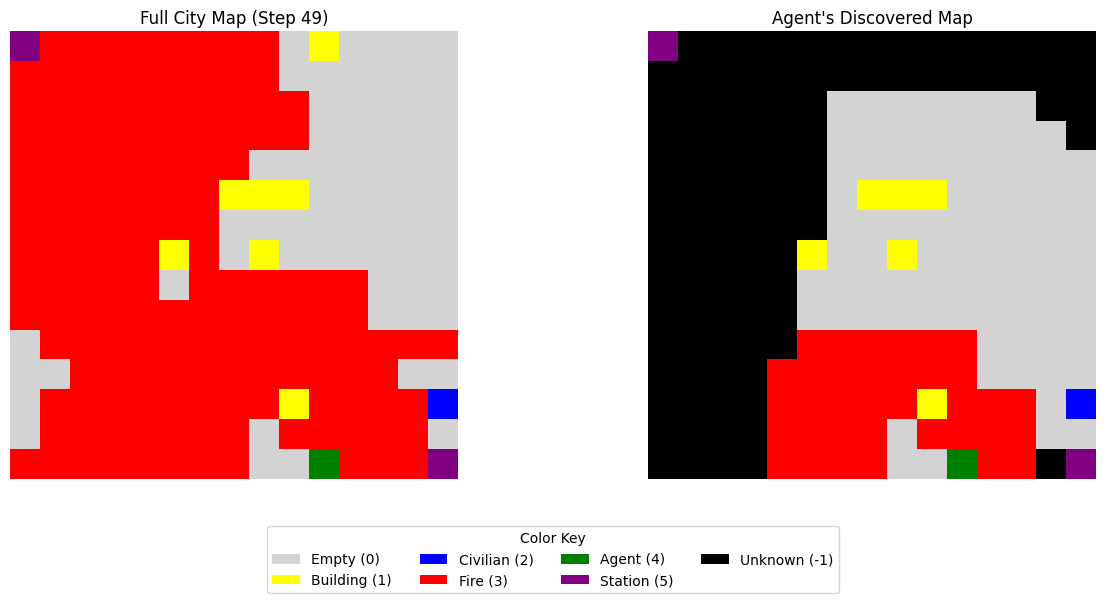

Step 49
LLM Action: move down
Reasoning: To move down towards the nearest station at (14, 14) and deliver the civilian, which aligns with the goal of rescuing and delivering civilians.
Invalid action: move down. Choosing fallback action.
Fallback Action: move up
Civilian died in fire! Score/MQ: -640


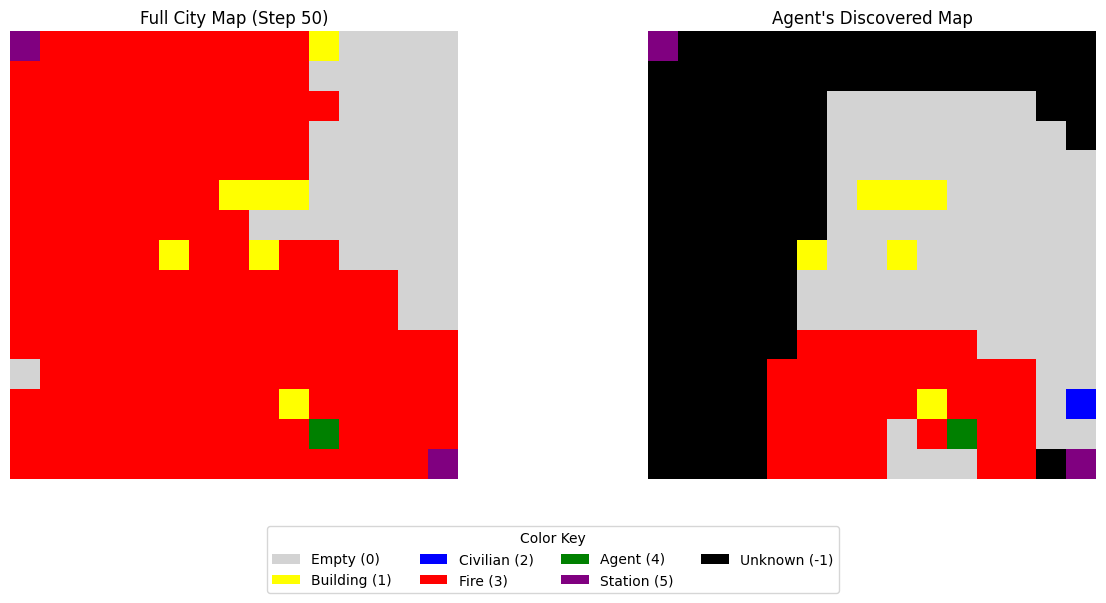

Game Over! Final Score: -640
Fires extinguished: 6
Civilians rescued: 0/8

LLM Responses for All Steps:

Step 0:
Prompt:

[AGENT STATE]
Gird size:(15, 15)
Position: (4, 8)
Sensor View: [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 4, 0, 0], [0, 1, 1, 1, 0], [0, 0, 0, 0, 0]]
Known Fires: []
Known Civilians: []
Carrying Civilian: No
Last Cell Content: 0 (0=Empty, 2=Civilian, 3=Fire, 5=Station)
Nearest Station: (0, 0) (Distance: 12)
Score: 0
Time Left: 50 steps

[GOAL AND PRIORITY]
Extinguish fires, rescue civilians, and avoid penalties.

[ACTION]
Choose one valid action from the following:
- Move up: Move to (3, 8) if not a building or out of bounds(15, 15)
- Move down: Move to (5, 8) if not a building or out of bounds(15, 15)
- Move left: Move to (4, 7) if not a building or out of bounds(15, 15)
- Move right: Move to (4, 9) if not a building or out of bounds(15, 15)
- Extinguish fire: If last cell content was a fire
- Rescue civilian: If last cell content was a civilian and not carrying one

In [39]:
await run_simulation()